In [13]:
# Here’s a **checklist-style breakdown** of plots, charts, and visualizations you should include to create a **professional, publishable-grade results section**:

# ---

# ## 📊 1. **Training and Validation Curves**
# **Purpose**: Show training stability, convergence, and overfitting

# - ✅ Loss curves: train vs validation loss per epoch
# - ✅ AUROC curves: train vs validation AUROC per epoch
# - ✅ Partial AUC (custom metric) over epochs (optional)
# - ✅ Learning rate scheduler curve (if using cosine annealing)

# ---

# ## 📈 2. **Performance Metrics by Fold (Bar or Box Plots)**
# **Purpose**: Show how consistent your model is across folds

# - ✅ Bar chart: AUROC per fold (train/val)
# - ✅ Bar chart or table: Partial AUC per fold
# - ✅ Box plot: Distribution of AUROC scores across folds
# - ✅ Table of mean ± std of metrics

# ---

# ## 🧠 3. **Confusion Matrices**
# **Purpose**: Show detailed classification performance

# - ✅ Confusion matrix for:
#   - Validation set (binary)
#   - Optional: multi-class if 3-class model used
# - ✅ Include precision, recall, F1-score

# ---

# ## 🧪 4. **ROC Curves**
# **Purpose**: Visualize model threshold behavior

# - ✅ ROC curve for each fold (or averaged)
# - ✅ Show shaded area for partial AUC (e.g., FPR ≤ 0.2)
# - ✅ Optional: compare CNN vs ensemble GBDT

# ---

# ## 🔍 5. **Error Analysis Plots**
# **Purpose**: Understand what the model gets wrong

# - ✅ Histogram of prediction confidence (true positive vs false positive)
# - ✅ Scatter plots of CNN prediction vs true label
# - ✅ Overlay distribution of benign vs malignant confidence
# - ✅ Hard samples: show examples where model fails (false negatives especially)

# ---

# ## 🧬 6. **Class Activation Maps (CAM/Grad-CAM)**
# **Purpose**: Show model explainability on image regions

# - ✅ Grad-CAM heatmaps overlaid on:
#   - Correct benign
#   - Correct malignant
#   - Misclassified malignant (false negatives)
# - ✅ Visualize on synthetic images too (if used)
# - ✅ Side-by-side: image, CAM, prediction

# ---

# ## 📎 7. **Explainability & Feature Importance**
# **Purpose**: Make model interpretable (esp. for GBDT)

# - ✅ SHAP or ELI5 for tabular GBDT models:
#   - Top features
#   - Per-patient explanations
# - ✅ Visualize distribution of top features across classes
# - ✅ Show which CNN output features were most helpful in ensemble

# ---

# ## 🧫 8. **Visual Analysis of Augmentations**
# **Purpose**: Justify data pipeline

# - ✅ Grid of before/after augmented samples
# - ✅ Specifically for positive class (melanoma)
# - ✅ Optional: synthetic sample visualization comparison

# ---

# ## 🔁 9. **Snapshot Ensemble Performance**
# **Purpose**: Show benefit of ensembling checkpoints

# - ✅ Line/bar chart: AUROC of epoch 40, 45, 50 models
# - ✅ AUROC of their ensemble (average prediction)
# - ✅ Histogram of prediction variance across snapshots (model stability)

# ---

# ## 🧬 10. **Synthetic Data Evaluation (if used)**
# **Purpose**: Show benefit or challenge of using synthetic positives

# - ✅ AUROC with vs without synthetic data
# - ✅ Visual comparison of real vs synthetic lesion images
# - ✅ Grad-CAM on synthetic images
# - ✅ Distribution of CNN confidence for synthetic vs real malignant

# ---

# ## 🧪 Bonus Ideas (if time permits)
# - ✅ t-SNE / UMAP of CNN features (last layer): show clustering by class
# - ✅ Patient-level analysis (how consistent are predictions for same patient?)
# - ✅ Calibration curves: is predicted probability well-calibrated?

# ---

# ## 🎓 Presentation Tip

# For your class talk, highlight:
# - Visuals (CAMs, confusion matrix, ROC curve)
# - Real vs synthetic examples
# - Metrics chart
# - Ensemble performance gains

# ---

In [14]:
# # !pip install timm==1.0.9
# # !pip install albumentations==1.4.14
# !pip install torcheval==0.0.7
# # !pip install pandas==2.2.2
# !pip install numpy==1.26.4
# !pip install pyarrow

# Imports

In [3]:
import sys, os, time, copy, gc
import torch
from torch import nn
from torch.utils.data import DataLoader
from pathlib import Path
import glob
import numpy as np
import pandas as pd
import albumentations as A
from albumentations.pytorch import ToTensorV2
import multiprocessing as mp
import json
import shutil

from torcheval.metrics.functional import binary_auroc, multiclass_auroc

from sklearn.model_selection import StratifiedGroupKFold

import hashlib
from joblib import Parallel, delayed
from sklearn.model_selection import train_test_split

from PIL import Image
import torch.optim as optim

from collections import defaultdict


sys.path.append('../src')
from utils import set_seed, visualize_augmentations_positive, print_trainable_parameters
from models import setup_model
from training import fetch_scheduler, train_one_epoch, valid_one_epoch, run_training, get_nth_test_step, criterion, combined_criterion
from models import ISICModel, ISICModelSegL, ISICModelEdgnet, ISICModelEdgnetSegL, ISICModelEdgnet, setup_model
from datasets import ISICDatasetSamplerW, ISICDatasetSampler, ISICDatasetSimple, ISICDatasetSamplerMulticlass, prepare_loaders
from augmentations import get_augmentations

In [4]:
# Set up device and random seed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Number of GPUs: {torch.cuda.device_count()}")

Using device: cuda
GPU: NVIDIA GeForce RTX 3090 Ti
Number of GPUs: 1


In [5]:
original_data_path = "../data/original"
original_root = Path('../data/original')

data_artifacts = "../data/artifacts"
os.makedirs(data_artifacts, exist_ok=True)

In [6]:
# Set the HDF5 file path
TRAIN_HDF5_FILE_PATH = original_root / 'train-image.hdf5'

train_path = original_root / 'train-metadata.csv'
df_train = pd.read_csv(train_path)
df_train["path"] = '../data/original/train-image/image/' + df_train['isic_id'] + ".jpg"
original_positive_cases = df_train['target'].sum()
original_total_cases = len(df_train)
original_positive_ratio = original_positive_cases / original_total_cases

print(f"Number of positive cases: {original_positive_cases}")
print(f"Number of negative cases: {original_total_cases - original_positive_cases}")
print(f"Ratio of negative to positive cases: {(original_total_cases - original_positive_cases) / original_positive_cases:.2f}:1")

C:\Users\mdzh1\AppData\Local\Temp\ipykernel_29208\2927513113.py:5: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv(train_path)


Number of positive cases: 393
Number of negative cases: 400666
Ratio of negative to positive cases: 1019.51:1


In [7]:
# MODEL_NAME = "EVA" # "EDGENEXT"
MODEL_NAME = "EDGENEXT" 

CONFIG = {
    "seed": 42 if MODEL_NAME == 'EVA' else 1997,
    "epochs": 500,
    "img_size": 336 if MODEL_NAME == 'EVA' else 256,
    "train_batch_size": 32,
    "valid_batch_size": 64,
    "learning_rate": 1e-4,
    "scheduler": 'CosineAnnealingLR',
    "min_lr": 1e-6,
    "T_max": 2000,
    "weight_decay": 1e-6,
    "fold" : 0,
    "n_fold": 5,
    "n_accumulate": 1,
    "group_col": 'patient_id',
    "device": device
}

model_name = "eva02_small_patch14_336.mim_in22k_ft_in1k" if MODEL_NAME == 'EVA' else "edgenext_base.in21k_ft_in1k"
checkpoint_path = None


if MODEL_NAME == 'EVA':
    ISICModelPrep = ISICModel
else:
    ISICModelPrep = ISICModelEdgnet

# if MODEL_NAME == 'EVA':
#     ISICModelPrep = ISICModelSegL
# else:
#     ISICModelPrep = ISICModelEdgnetSegL

In [8]:
data_transforms = get_augmentations(CONFIG)

c:\Users\mdzh1\.conda\envs\torch2\Lib\site-packages\albumentations\core\validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
d:\Work\UNT\UNT Coursework\Spring 25\CSCE 5218\Project\isic-2024-challenge\notebooks\../src\augmentations.py:22: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5.0, 30.0)),
d:\Work\UNT\UNT Coursework\Spring 25\CSCE 5218\Project\isic-2024-challenge\notebooks\../src\augmentations.py:31: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(


In [7]:
# synthetic_custom_data = f"../data/artifacts/syntetic_custom_base_{CONFIG['seed']}"
# os.makedirs(synthetic_custom_data, exist_ok=True)

# tsp = StratifiedGroupKFold(2, shuffle=True, random_state=CONFIG['seed'])
# metrics_ev_df = []
# test_forecast = []
# val_forecast = []
# for fold_n, (train_index, val_index) in enumerate(tsp.split(df_train, y=df_train.target, groups=df_train[CONFIG["group_col"]])):
#     fold_df_train = df_train.iloc[train_index].reset_index(drop=True)
#     fold_df_valid = df_train.iloc[val_index].reset_index(drop=True)
#     synthetic_custom_data_pr = os.path.join(synthetic_custom_data, str(fold_n))
#     os.makedirs(synthetic_custom_data_pr, exist_ok=True)

#     for fn in fold_df_train[fold_df_train.target==1].isic_id.values:
#         if fn not in images_to_include:
#             continue
#         img = Image.open(os.path.join('../data/original/train-image/image', fn + ".jpg"))
#         img.save(os.path.join(synthetic_custom_data_pr, fn + ".png"))
    

In [22]:
folder_name = f"../weights/oof_{MODEL_NAME.lower()}_segl"
os.makedirs(folder_name, exist_ok=True)

In [23]:
def get_metrics(drop_path_rate, drop_rate, models_folder, model_maker):
    tsp = StratifiedGroupKFold(2, shuffle=True, random_state=CONFIG['seed'])
    results_list = []
    fold_df_valid_list = []
    for fold_n, (train_index, val_index) in enumerate(tsp.split(df_train, y=df_train.target, groups=df_train[CONFIG["group_col"]])):
        fold_df_train = df_train.iloc[train_index].reset_index(drop=True)
        fold_df_valid = df_train.iloc[val_index].reset_index(drop=True)
        set_seed(CONFIG['seed'])
        model = setup_model(model_name, drop_path_rate=drop_path_rate, drop_rate=drop_rate, model_maker=model_maker)
        print_trainable_parameters(model)

        train_loader, valid_loader = prepare_loaders(fold_df_train, fold_df_valid, CONFIG, data_transforms)
    
        optimizer = optim.Adam(model.parameters(), lr=CONFIG['learning_rate'], 
                           weight_decay=CONFIG['weight_decay'])
        scheduler = fetch_scheduler(optimizer, CONFIG)
    
        model, history = run_training(
            train_loader, valid_loader,
            model, optimizer, scheduler,
            device=CONFIG['device'],
            num_epochs=CONFIG['epochs'],
            CONFIG=CONFIG, 
            tolerance_max=20,
            test_every_nth_step=lambda x: 5,
            seed=CONFIG['seed'])
        torch.save(model.state_dict(), os.path.join(models_folder, f"model__{fold_n}"))

        # Save history as JSON
        with open(os.path.join(models_folder, f"history__{fold_n}.json"), "w") as f:
            json.dump(history, f)

        results_list.append(np.max(history['Valid Kaggle metric']))

        val_epoch_loss, val_epoch_auroc, val_epoch_custom_metric, tmp_predictions_all, tmp_targets_all = valid_one_epoch(
            model, 
            valid_loader, 
            device=CONFIG['device'], 
            epoch=1, 
            optimizer=optimizer, 
            criterion=combined_criterion, 
            use_custom_score=True,
            metric_function=binary_auroc, 
            num_classes=1,
            return_preds=True)
        
        # Save preds/targets
        np.save(os.path.join(models_folder, f"preds_fold{fold_n}.npy"), tmp_predictions_all)
        np.save(os.path.join(models_folder, f"targets_fold{fold_n}.npy"), tmp_targets_all)

        # Save CAM-worthy top predictions
        cam_dir = f"{models_folder}/cam_samples/fold{fold_n}"
        os.makedirs(cam_dir, exist_ok=True)
        top_idxs = np.argsort(-tmp_predictions_all)[:10]  # top confident predictions
        for i in top_idxs:
            img_path = fold_df_valid.iloc[i].path
            target = fold_df_valid.iloc[i].target
            img_name = os.path.basename(img_path)
            save_name = f"{cam_dir}/target{target}_conf_{tmp_predictions_all[i]:.2f}_{img_name}"
            try:
                shutil.copy(img_path, save_name)
            except:
                pass  # if file missing

        fold_df_valid['tmp_targets_all'] = tmp_targets_all
        fold_df_valid['tmp_predictions_all'] = tmp_predictions_all
        fold_df_valid['fold_n'] = fold_n
        fold_df_valid_list.append(fold_df_valid)
    fold_df_valid_list = pd.concat(fold_df_valid_list).reset_index(drop=True)
    return results_list, fold_df_valid_list

In [24]:
base_metrics, oof_forecasts = get_metrics(drop_path_rate=0, drop_rate=0, models_folder=folder_name, model_maker=ISICModelPrep)
oof_forecasts.to_parquet(f'../data/artifacts/oof_forecasts_{MODEL_NAME.lower()}_segl.parquet')

trainable params: 21744002 || all params: 21744002 || trainable%: 100.00


100%|██████████| 13/13 [00:06<00:00,  1.94it/s, Epoch=1, LR=0.0001, Train_Auroc=0.474, Train_Loss=1.57]


100%|██████████| 13/13 [00:05<00:00,  2.18it/s, Epoch=2, LR=0.0001, Train_Auroc=0.562, Train_Loss=1.28]


100%|██████████| 13/13 [00:06<00:00,  2.13it/s, Epoch=3, LR=9.99e-5, Train_Auroc=0.63, Train_Loss=1.17] 


100%|██████████| 13/13 [00:06<00:00,  2.14it/s, Epoch=4, LR=9.98e-5, Train_Auroc=0.725, Train_Loss=0.741]


  0%|          | 0/3025 [00:02<?, ?it/s]


TypeError: criterion() takes 2 positional arguments but 4 were given

In [36]:
base_metrics

[0.14743336692881837, 0.14137451831305659]

In [ ]:
# eva --> [0.1537019221182075, 0.15297854038570258]
# edgenext --> [0.14743336692881837, 0.14137451831305659]


# Result Analysis with EdgeNext

### Basic Performance Summary Across Fold

In [14]:
import matplotlib.pyplot as plt

base_metrics = [0.14743336692881837, 0.14137451831305659]

print("Fold-wise Valid AUROC:")
for i, val in enumerate(base_metrics):
    print(f"Fold {i}: {val:.4f}")
print(f"Mean AUROC: {np.mean(base_metrics):.4f}")
print(f"Std Dev: {np.std(base_metrics):.4f}")


Fold-wise Valid AUROC:
Fold 0: 0.1474
Fold 1: 0.1414
Mean AUROC: 0.1444
Std Dev: 0.0030


### ROC Curve for OOF Predictions

In [6]:
import pandas as pd

MODEL_NAME = "EDGENEXT"
oof_path = f'../data/artifacts/oof_forecasts_{MODEL_NAME.lower()}_base.parquet'
oof_forecasts = pd.read_parquet(oof_path)

# print("OOF Data Loaded ✅")
# print(oof_forecasts.head())

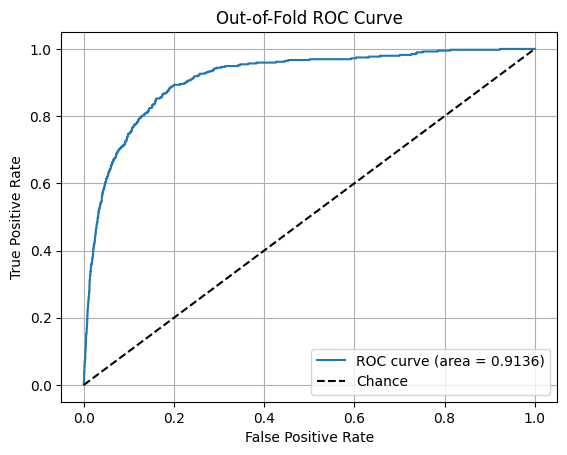

In [18]:
from sklearn.metrics import roc_curve, auc

y_true = oof_forecasts['tmp_targets_all'].values
y_scores = oof_forecasts['tmp_predictions_all'].values

fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Out-of-Fold ROC Curve')
plt.legend()
plt.grid(True)
plt.show()


### Confusion Matrix

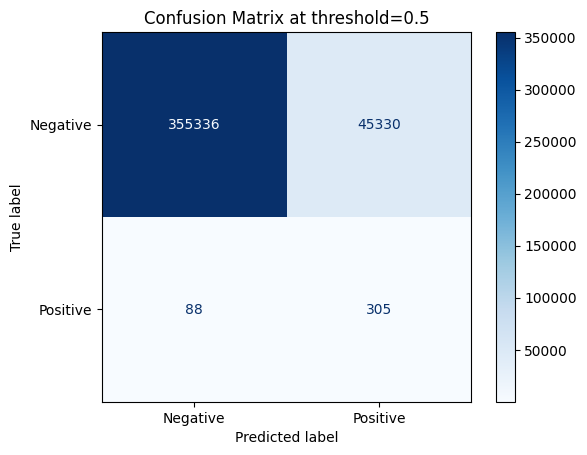

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

threshold = 0.5
pred_labels = (y_scores >= threshold).astype(int)

cm = confusion_matrix(y_true, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap='Blues')
plt.title(f"Confusion Matrix at threshold={threshold}")
plt.show()


### Error Analysis: False Positives / False Negatives

In [20]:
false_pos = oof_forecasts[(pred_labels == 1) & (y_true == 0)]
false_neg = oof_forecasts[(pred_labels == 0) & (y_true == 1)]

print(f"False Positives: {len(false_pos)}")
print(f"False Negatives: {len(false_neg)}")

# Save a few misclassified images to a folder
def save_misclassified(df, folder_name, tag):
    os.makedirs(folder_name, exist_ok=True)
    for idx, row in df.head(20).iterrows():
        src = row['path']
        conf = row['tmp_predictions_all']
        label = row['tmp_targets_all']
        img_name = os.path.basename(src)
        dst = f"{folder_name}/{tag}_label{label}_conf{conf:.2f}_{img_name}"
        try:
            shutil.copy(src, dst)
        except:
            pass

save_misclassified(false_pos, f"{data_artifacts}/false_pos", "FP")
save_misclassified(false_neg, f"{data_artifacts}/false_neg", "FN")


False Positives: 45330
False Negatives: 88


### Distribution of Prediction Scores

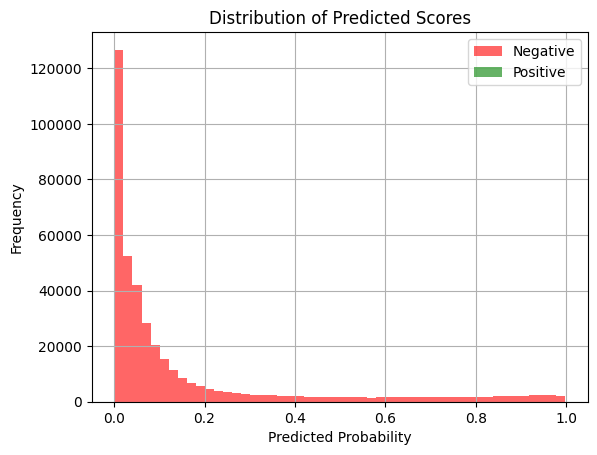

In [21]:
plt.hist(y_scores[y_true == 0], bins=50, alpha=0.6, label='Negative', color='red')
plt.hist(y_scores[y_true == 1], bins=50, alpha=0.6, label='Positive', color='green')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Scores')
plt.legend()
plt.grid(True)
plt.show()

### Per-Fold AUROC Distribution Boxplot

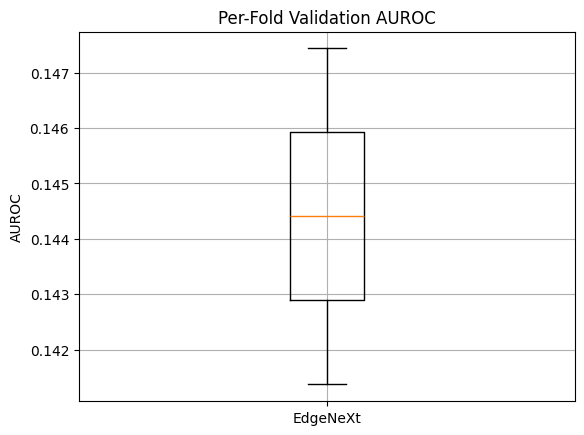

In [22]:
plt.boxplot(base_metrics)
plt.xticks([1], ['EdgeNeXt'])
plt.title('Per-Fold Validation AUROC')
plt.ylabel('AUROC')
plt.grid(True)
plt.show()


### Gradcam Analysis

In [9]:
import torch
from torchvision import transforms
# from torchcam.methods import GradCAM
# from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image
from PIL import Image
import matplotlib.pyplot as plt
import os

# Load the model
model = setup_model(
    model_name="edgenext_base.in21k_ft_in1k",
    drop_path_rate=0.0,
    drop_rate=0.0,
    model_maker=ISICModelEdgnet  # already defined in your script
)
checkpoint_path = "../weights/oof_edgenext_base/model__0"
model.load_state_dict(torch.load(checkpoint_path, map_location='cpu'))
model.eval().to(device)


C:\Users\mdzh1\AppData\Local\Temp\ipykernel_29208\934706454.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_locati

ISICModelEdgnet(
  (model): EdgeNeXt(
    (stem): Sequential(
      (0): Conv2d(3, 80, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((80,), eps=1e-06, elementwise_affine=True)
    )
    (stages): Sequential(
      (0): EdgeNeXtStage(
        (downsample): Identity()
        (blocks): Sequential(
          (0): ConvBlock(
            (conv_dw): Conv2d(80, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=80)
            (norm): LayerNorm((80,), eps=1e-06, elementwise_affine=True)
            (mlp): Mlp(
              (fc1): Linear(in_features=80, out_features=320, bias=True)
              (act): GELU(approximate='none')
              (drop1): Dropout(p=0.0, inplace=False)
              (norm): Identity()
              (fc2): Linear(in_features=320, out_features=80, bias=True)
              (drop2): Dropout(p=0.0, inplace=False)
            )
            (drop_path): Identity()
          )
          (1): ConvBlock(
            (conv_dw): Conv2d(80, 80, kernel_size

In [29]:
# # Pick a high-confidence image
# example_row = oof_forecasts.sort_values('tmp_predictions_all', ascending=False).iloc[0]
# img_path = example_row['path']
# true_label = example_row['tmp_targets_all']
# print(f"Image path: {img_path}, True label: {true_label}")

# # Load image
# image = Image.open(img_path).convert("RGB")
# transform = A.Compose([
#     A.Resize(CONFIG['img_size'], CONFIG['img_size']),
#     A.Normalize(),
#     ToTensorV2()
# ])
# transformed = transform(image=np.array(image))['image'].unsqueeze(0).to(device)


In [26]:
# Print last few conv layers
for name, module in model.named_modules():
    if isinstance(module, torch.nn.Conv2d):
        print(name)


model.stem.0
model.stages.0.blocks.0.conv_dw
model.stages.0.blocks.1.conv_dw
model.stages.0.blocks.2.conv_dw
model.stages.1.downsample.1
model.stages.1.blocks.0.conv_dw
model.stages.1.blocks.1.conv_dw
model.stages.1.blocks.2.convs.0
model.stages.1.blocks.2.pos_embd.token_projection
model.stages.2.downsample.1
model.stages.2.blocks.0.conv_dw
model.stages.2.blocks.1.conv_dw
model.stages.2.blocks.2.conv_dw
model.stages.2.blocks.3.conv_dw
model.stages.2.blocks.4.conv_dw
model.stages.2.blocks.5.conv_dw
model.stages.2.blocks.6.conv_dw
model.stages.2.blocks.7.conv_dw
model.stages.2.blocks.8.convs.0
model.stages.2.blocks.8.convs.1
model.stages.3.downsample.1
model.stages.3.blocks.0.conv_dw
model.stages.3.blocks.1.conv_dw
model.stages.3.blocks.2.convs.0
model.stages.3.blocks.2.convs.1
model.stages.3.blocks.2.convs.2


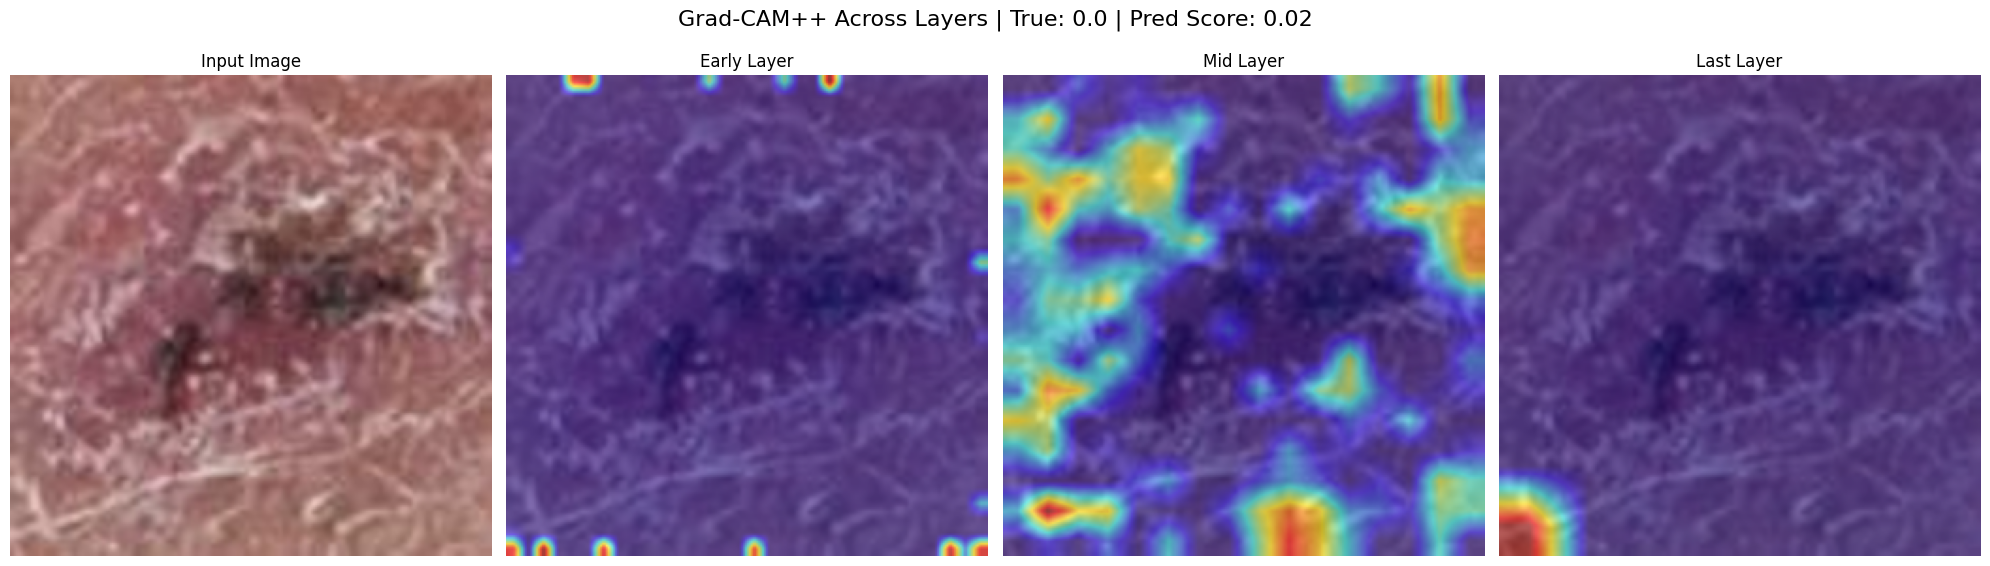

In [49]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

import albumentations as A
from albumentations.pytorch import ToTensorV2

# ------------------- CONFIG -------------------
# Select layers manually from model structure
target_layers = {
    "Early Layer": model.model.stages[1].blocks[2].convs[0],
    "Mid Layer": model.model.stages[2].blocks[8].convs[1],
    "Last Layer": model.model.stages[3].blocks[2].convs[2]
}

# Pick one image (e.g., high confidence from oof)
example_row = oof_forecasts.sort_values('tmp_predictions_all', ascending=False).iloc[0]
img_path = example_row['path']
true_label = example_row['tmp_targets_all']

# ------------------- IMAGE PREP -------------------
image = Image.open(img_path).convert("RGB")
original_size = image.size
img_np = np.array(image)

# Resize + normalize (same as training)
transform = A.Compose([
    A.Resize(CONFIG['img_size'], CONFIG['img_size']),
    A.Normalize(),
    ToTensorV2()
])
transformed = transform(image=img_np)
input_tensor = transformed['image'].unsqueeze(0).to(device)

# Also prepare image in [0,1] float format for visualization
rgb_img = np.float32(image.resize((CONFIG['img_size'], CONFIG['img_size']))) / 255.0

# ------------------- GRADCAM++ -------------------
visualizations = [image.resize((CONFIG['img_size'], CONFIG['img_size']))]  # original input image first
model.eval()
for label, layer in target_layers.items():
    cam = GradCAM(model=model, target_layers=[layer])
    targets = [ClassifierOutputTarget(0)]  # binary classification

    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]  # CAM for first image in batch
    cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
    visualizations.append((label, cam_image))

# ------------------- PLOT -------------------
plt.figure(figsize=(20, 6))

# Plot original input image
plt.subplot(1, 4, 1)
plt.imshow(visualizations[0])
plt.title("Input Image")
plt.axis("off")

# Plot each CAM result
for idx, (label, cam_img) in enumerate(visualizations[1:], start=2):
    plt.subplot(1, 4, idx)
    plt.imshow(cam_img)
    plt.title(label)
    plt.axis("off")

pred_score = oof_forecasts['tmp_predictions_all'].iloc[0]
plt.suptitle(f"Grad-CAM++ Across Layers | True: {true_label} | Pred Score: {pred_score:.2f}", fontsize=16)
plt.tight_layout()
plt.show()


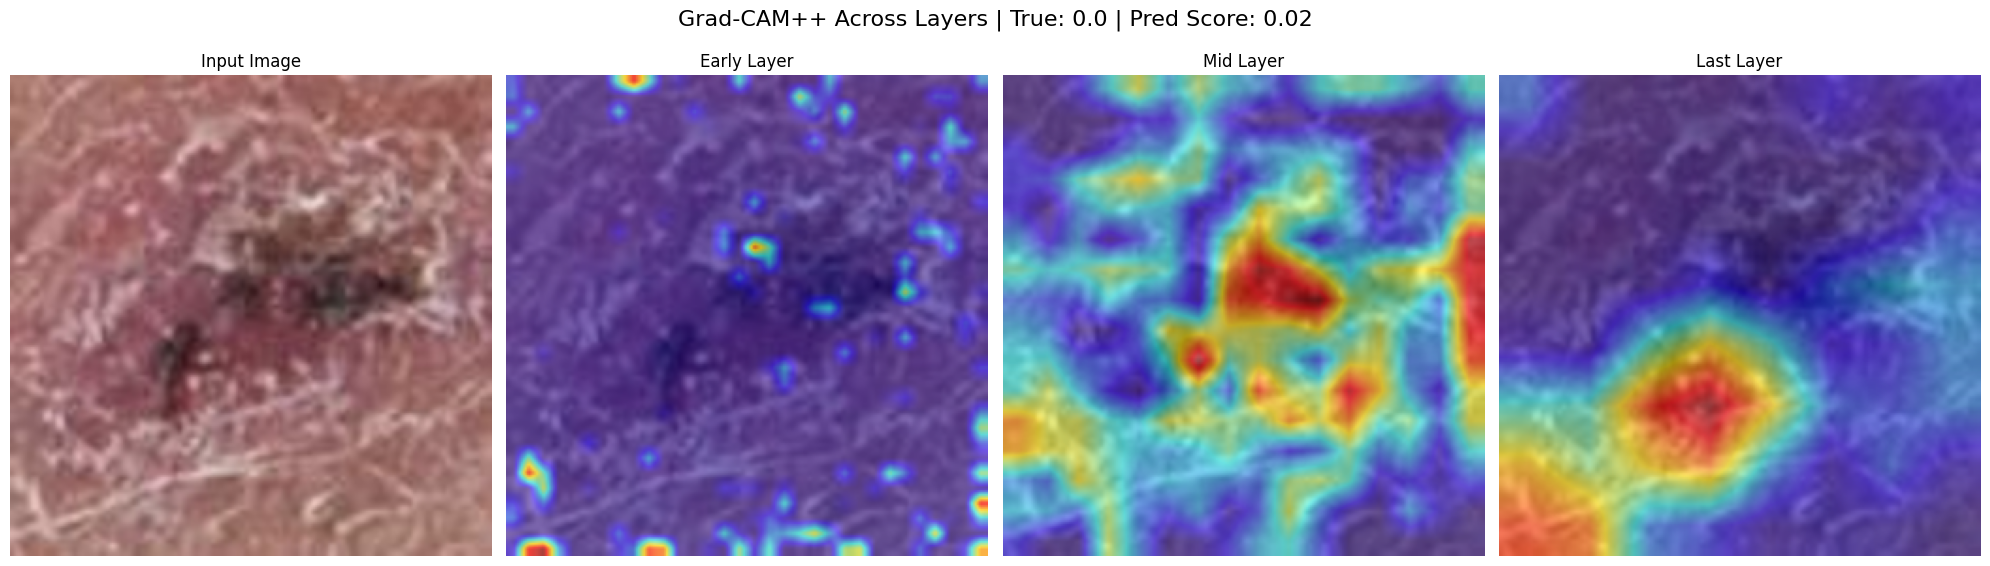

In [50]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from pytorch_grad_cam import GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

import albumentations as A
from albumentations.pytorch import ToTensorV2

# ------------------- CONFIG -------------------
# Select layers manually from model structure
target_layers = {
    "Early Layer": model.model.stages[1].blocks[2].convs[0],
    "Mid Layer": model.model.stages[2].blocks[8].convs[1],
    "Last Layer": model.model.stages[3].blocks[2].convs[2]
}

# Pick one image (e.g., high confidence from oof)
example_row = oof_forecasts.sort_values('tmp_predictions_all', ascending=False).iloc[0]
img_path = example_row['path']
true_label = example_row['tmp_targets_all']

# ------------------- IMAGE PREP -------------------
image = Image.open(img_path).convert("RGB")
original_size = image.size
img_np = np.array(image)

# Resize + normalize (same as training)
transform = A.Compose([
    A.Resize(CONFIG['img_size'], CONFIG['img_size']),
    A.Normalize(),
    ToTensorV2()
])
transformed = transform(image=img_np)
input_tensor = transformed['image'].unsqueeze(0).to(device)

# Also prepare image in [0,1] float format for visualization
rgb_img = np.float32(image.resize((CONFIG['img_size'], CONFIG['img_size']))) / 255.0

# ------------------- GRADCAM++ -------------------
visualizations = [image.resize((CONFIG['img_size'], CONFIG['img_size']))]  # original input image first
model.eval()
for label, layer in target_layers.items():
    cam = GradCAMPlusPlus(model=model, target_layers=[layer])
    targets = [ClassifierOutputTarget(0)]  # binary classification

    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]  # CAM for first image in batch
    cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
    visualizations.append((label, cam_image))

# ------------------- PLOT -------------------
plt.figure(figsize=(20, 6))

# Plot original input image
plt.subplot(1, 4, 1)
plt.imshow(visualizations[0])
plt.title("Input Image")
plt.axis("off")

# Plot each CAM result
for idx, (label, cam_img) in enumerate(visualizations[1:], start=2):
    plt.subplot(1, 4, idx)
    plt.imshow(cam_img)
    plt.title(label)
    plt.axis("off")

pred_score = oof_forecasts['tmp_predictions_all'].iloc[0]
plt.suptitle(f"Grad-CAM++ Across Layers | True: {true_label} | Pred Score: {pred_score:.2f}", fontsize=16)
plt.tight_layout()
plt.show()


In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from torchvision import transforms
from PIL import Image
import os

# ---------------------------------------------------------------------------
# 0. Device configuration
# ---------------------------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------------------------------------------------------------------
# 1. Load the model
# ---------------------------------------------------------------------------
# Assuming that setup_model and ISICModelEdgnet are defined in your script
model = setup_model(
    model_name="edgenext_base.in21k_ft_in1k",
    drop_path_rate=0.0,

    drop_rate=0.0,
    model_maker=ISICModelEdgnet  # your custom model maker
)
checkpoint_path = "../weights/oof_edgenext_base/model__0"
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model = model.to(device)
model.eval()

# ---------------------------------------------------------------------------
# 2. Prepare the test data: load the input image and its corresponding mask
# ---------------------------------------------------------------------------
# Get an example from your dataframe (assumed to be defined as oof_forecasts)
example_row = oof_forecasts.sort_values('tmp_predictions_all', ascending=False).iloc[0]
img_path = example_row['path']
true_label = example_row['tmp_targets_all']
# print(img_path)

# Optionally, you might also have the ground-truth mask path available in your dataframe.
# Here we derive it by replacing 'image' with 'masks_pred' in the image path.
base_filename = os.path.basename(img_path)
mask_filename = base_filename.replace(".jpg", ".png")
mask_dir = "../data/original/train-image/masks_pred/"
mask_path = os.path.join(mask_dir, mask_filename)
# print(mask_path)

# Read the input image
image_pil = Image.open(img_path).convert('RGB')
transform_img = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])
image = transform_img(image_pil).unsqueeze(0).to(device)  # shape: (1, 3, H, W)

# Read the mask of the input image
if not os.path.exists(mask_path):
    raise FileNotFoundError(f"Mask file not found: {mask_path}")
mask_pil = Image.open(mask_path).convert('L')  # convert to grayscale
transform_mask = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])
mask = transform_mask(mask_pil).unsqueeze(0).to(device)  # shape: (1, 1, H, W)

# ---------------------------------------------------------------------------
# 3. Set up GradCAM++ on the model's last layer
# ---------------------------------------------------------------------------
chosen_layer = model.model.stages[3].blocks[2].convs[2]  # adjust if needed (e.g., may be a specific block or conv)
cam = GradCAMPlusPlus(model=model, target_layers=[chosen_layer])

# Convert true_label to an integer for the target class index.
target_class = 1
targets = [ClassifierOutputTarget(target_class) for _ in range(image.size(0))]

# Generate the GradCAM++ heatmap (returns a numpy array of shape: (B, H_cam, W_cam))
grayscale_cam = cam(input_tensor=image, targets=targets)

# Convert the CAM output to a torch tensor
cam_tensor = torch.tensor(grayscale_cam, device=device, dtype=torch.float32)

# Upsample the CAM to match the mask dimensions if necessary.
if cam_tensor.shape[-2:] != mask.shape[-2:]:
    cam_tensor = F.interpolate(cam_tensor.unsqueeze(1), size=mask.shape[-2:], mode='bilinear', align_corners=False).squeeze(1)

# Create a binarized version of the CAM using a threshold (0.5 here)
threshold = 0.5
binarized_cam = (cam_tensor > threshold).float()

# ---------------------------------------------------------------------------
# 4. Convert tensors to numpy arrays for visualization
# ---------------------------------------------------------------------------
img_np = image[0].detach().cpu().permute(1, 2, 0).numpy()      # (H, W, C)
mask_np = mask[0].squeeze(0).detach().cpu().numpy()               # (H, W)
gradcam_heatmap_np = cam_tensor[0].detach().cpu().numpy()           # continuous heatmap
gradcam_mask_np = binarized_cam[0].detach().cpu().numpy()           # binarized mask

# ---------------------------------------------------------------------------
# 5. Plot and visualize the outputs
# ---------------------------------------------------------------------------

fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# Original image
axs[0].imshow(img_np)
axs[0].set_title("Original Image")
axs[0].axis('off')

# Original mask
axs[1].imshow(mask_np, cmap='gray')
axs[1].set_title("Original Mask")
axs[1].axis('off')

# GradCAM++ continuous heatmap (using jet or any color map)
axs[2].imshow(gradcam_heatmap_np, cmap='jet')
axs[2].set_title("GradCAM++ Heatmap")
axs[2].axis('off')

# GradCAM++ *binarized* mask in black and white
axs[3].imshow(gradcam_mask_np, cmap='gray', vmin=0, vmax=1)
axs[3].set_title("GradCAM++ Mask (Binarized)")
axs[3].axis('off')

plt.tight_layout()
plt.show()

C:\Users\mdzh1\AppData\Local\Temp\ipykernel_29208\1241572273.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_locat

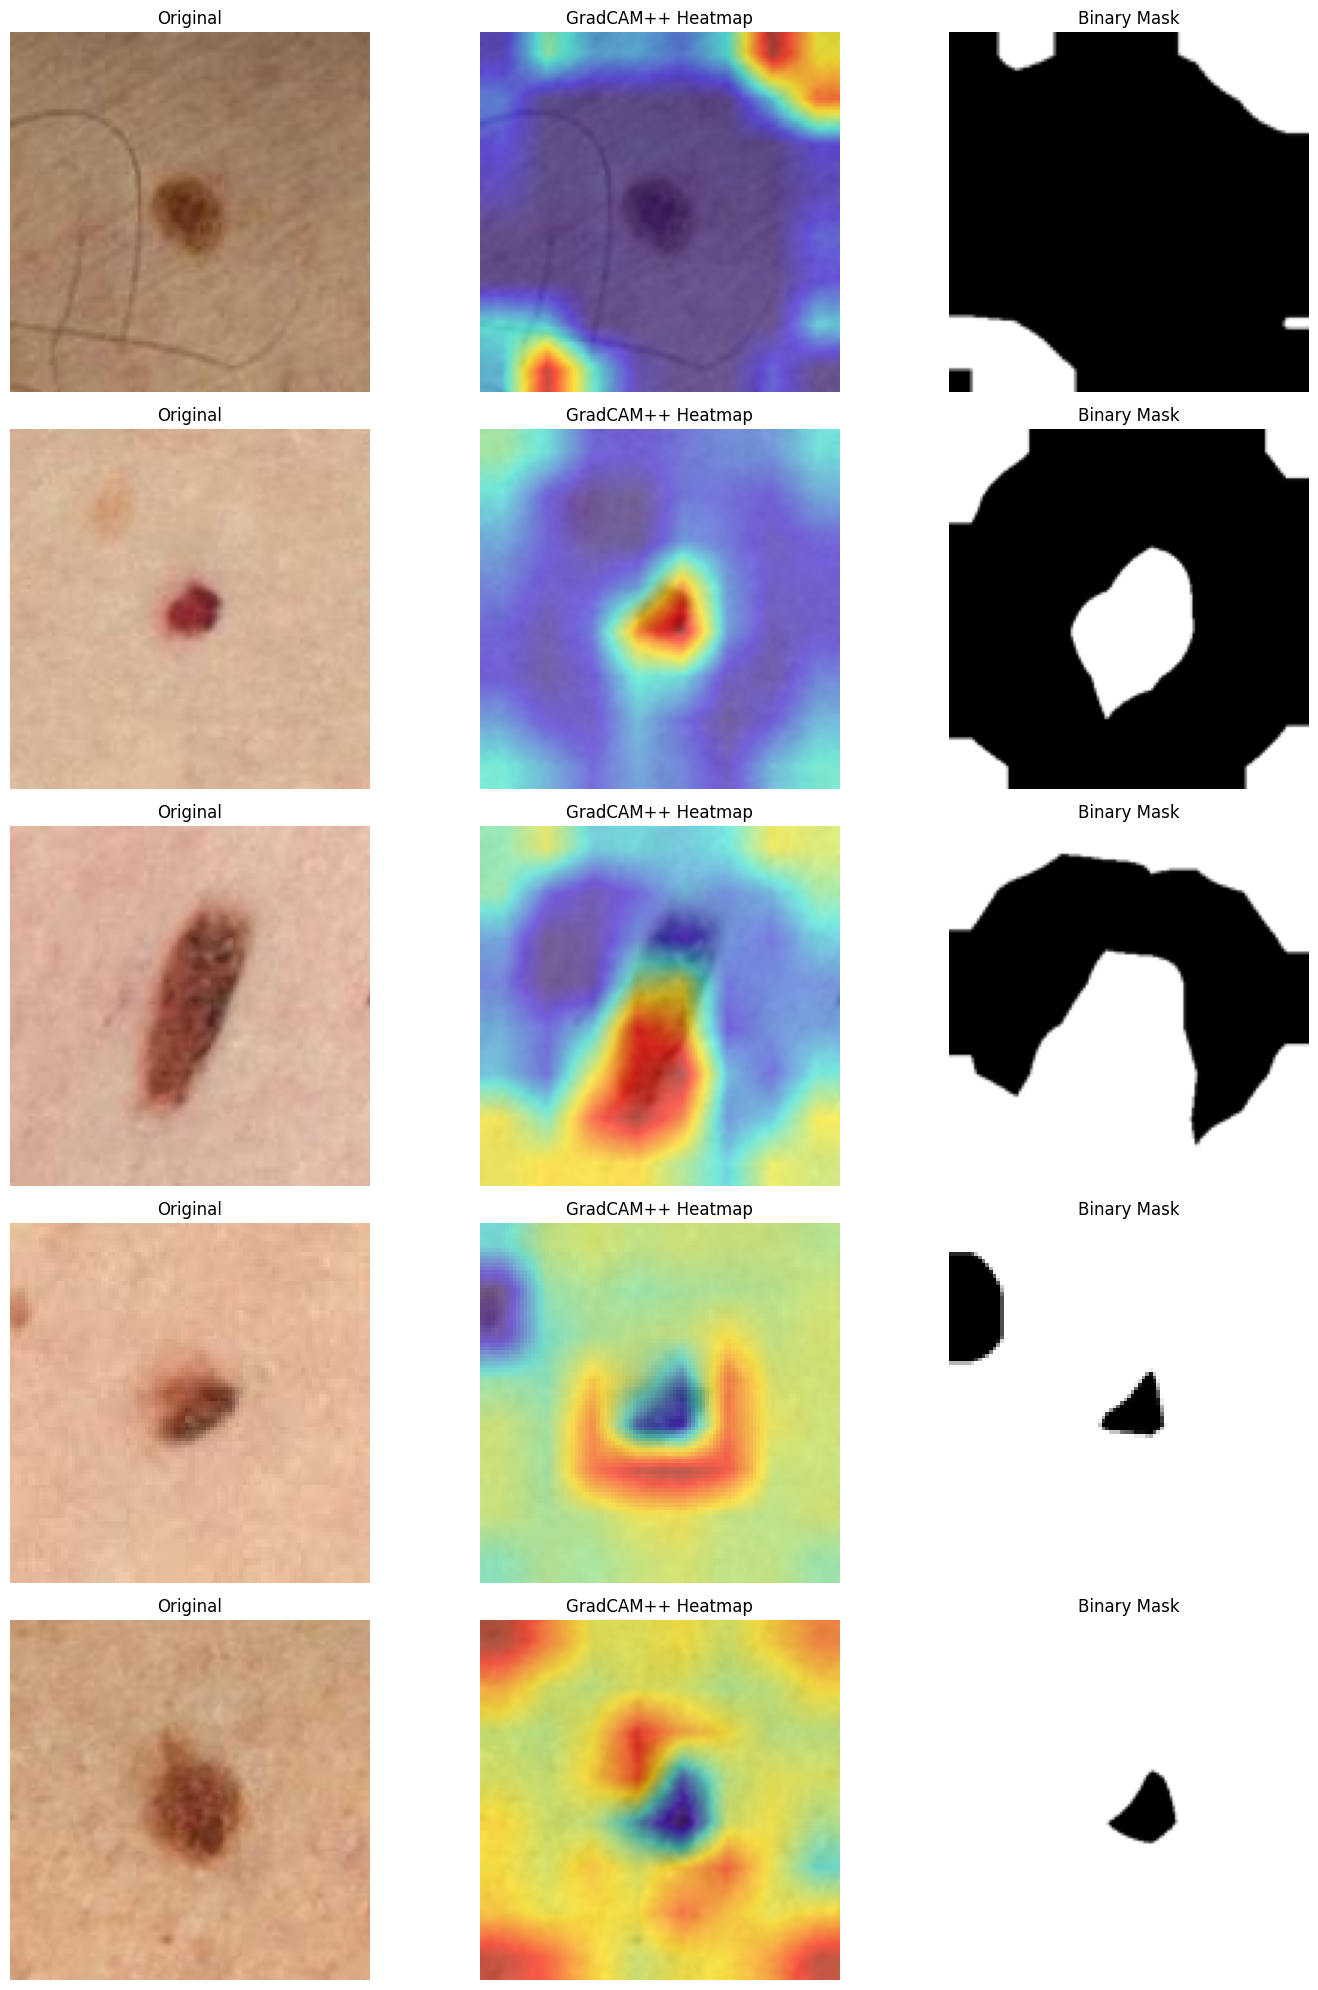

: 

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from pytorch_grad_cam import GradCAMPlusPlus, GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

import albumentations as A
from albumentations.pytorch import ToTensorV2
import pandas as pd
from tqdm import tqdm
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load model
model = setup_model(
    model_name="edgenext_base.in21k_ft_in1k",
    drop_path_rate=0.0,
    drop_rate=0.0,
    model_maker=ISICModelPrep
)
checkpoint_path = "../weights/oof_edgenext_base/model__0"
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.eval().to(device)

MODEL_NAME = "EDGENEXT"
oof_path = f'../data/artifacts/oof_forecasts_{MODEL_NAME.lower()}_base.parquet'
oof_forecasts = pd.read_parquet(oof_path)

# print("OOF Data Loaded ✅")
# print(oof_forecasts.head())

# Folder paths
input_folder = "../sample1/"   # your input image folder
output_folder = "../sample1/masks"   # folder to save cam masks
os.makedirs(output_folder, exist_ok=True)

# Transform (same as training)
transform = A.Compose([
    A.Resize(CONFIG['img_size'], CONFIG['img_size']),
    A.Normalize(),
    ToTensorV2()
])

# Only last layer for CAM
target_layer = model.model.stages[3].blocks[2].convs[2]

cam = GradCAMPlusPlus(model=model, target_layers=[target_layer])

# Store data for plotting
plot_images = []
plot_cams = []
plot_masks = []
valid_exts = ['.jpg', '.jpeg', '.png']

image_files = [f for f in os.listdir(input_folder) if os.path.splitext(f)[-1].lower() in valid_exts]

for idx, img_name in enumerate(tqdm(image_files)):
    img_path = os.path.join(input_folder, img_name)

    image = Image.open(img_path).convert("RGB")
    img_np = np.array(image)

    transformed = transform(image=img_np)
    input_tensor = transformed['image'].unsqueeze(0).to(device)

    rgb_img = np.float32(image.resize((CONFIG['img_size'], CONFIG['img_size']))) / 255.0

    targets = [ClassifierOutputTarget(0)]
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]

    # GradCAM++ Heatmap Overlay
    cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    # Binary Mask from CAM
    binary_mask = (grayscale_cam > 0.3).astype(np.uint8) * 255

    mask_img = Image.fromarray(binary_mask).resize(image.size)

    # Save Binary Mask
    save_path = os.path.join(output_folder, img_name.replace('.jpg', '.png').replace('.jpeg', '.png'))
    mask_img.save(save_path)

    # Store for plotting (first 5 images only)
    if idx < 5:
        plot_images.append(image)
        plot_cams.append(Image.fromarray(cam_image).resize(image.size))
        plot_masks.append(mask_img)

# ------------------ Plotting ------------------
plt.figure(figsize=(15, 20))

for idx in range(5):
    plt.subplot(5, 3, idx * 3 + 1)
    plt.imshow(plot_images[idx])
    plt.title("Original")
    plt.axis("off")

    plt.subplot(5, 3, idx * 3 + 2)
    plt.imshow(plot_cams[idx])
    plt.title("GradCAM++ Heatmap")
    plt.axis("off")

    plt.subplot(5, 3, idx * 3 + 3)
    plt.imshow(plot_masks[idx], cmap='gray')
    plt.title("Binary Mask")
    plt.axis("off")

plt.tight_layout()
plt.show()


# Result Analysis with EVA02

In [ ]:
# import torch
# import matplotlib.pyplot as plt
# import numpy as np
# from PIL import Image
# from pytorch_grad_cam import GradCAMPlusPlus
# from pytorch_grad_cam.utils.image import show_cam_on_image
# from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# import albumentations as A
# from albumentations.pytorch import ToTensorV2

# # ------------------- CONFIG -------------------
# # Select layers manually from model structure
# target_layers = {
#     "Early Layer": model.model.stages[1].blocks[2].convs[0],
#     "Mid Layer": model.model.stages[2].blocks[8].convs[1],
#     "Last Layer": model.model.stages[3].blocks[2].convs[2]
# }

# # Pick one image (e.g., high confidence from oof)
# example_row = oof_forecasts.sort_values('tmp_predictions_all', ascending=False).iloc[0]
# img_path = example_row['path']
# true_label = example_row['tmp_targets_all']

# # ------------------- IMAGE PREP -------------------
# image = Image.open(img_path).convert("RGB")
# original_size = image.size
# img_np = np.array(image)

# # Resize + normalize (same as training)
# transform = A.Compose([
#     A.Resize(CONFIG['img_size'], CONFIG['img_size']),
#     A.Normalize(),
#     ToTensorV2()
# ])
# transformed = transform(image=img_np)
# input_tensor = transformed['image'].unsqueeze(0).to(device)

# # Also prepare image in [0,1] float format for visualization
# rgb_img = np.float32(image.resize((CONFIG['img_size'], CONFIG['img_size']))) / 255.0

# # ------------------- GRADCAM++ -------------------
# visualizations = [image.resize((CONFIG['img_size'], CONFIG['img_size']))]  # original input image first
# model.eval()
# for label, layer in target_layers.items():
#     cam = GradCAMPlusPlus(model=model, target_layers=[layer])
#     targets = [ClassifierOutputTarget(0)]  # binary classification

#     grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]  # CAM for first image in batch
#     cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
#     visualizations.append((label, cam_image))

# # ------------------- PLOT -------------------
# plt.figure(figsize=(20, 6))

# # Plot original input image
# plt.subplot(1, 4, 1)
# plt.imshow(visualizations[0])
# plt.title("Input Image")
# plt.axis("off")

# # Plot each CAM result
# for idx, (label, cam_img) in enumerate(visualizations[1:], start=2):
#     plt.subplot(1, 4, idx)
#     plt.imshow(cam_img)
#     plt.title(label)
#     plt.axis("off")

# pred_score = oof_forecasts['tmp_predictions_all'].iloc[0]
# plt.suptitle(f"Grad-CAM++ Across Layers | True: {true_label} | Pred Score: {pred_score:.2f}", fontsize=16)
# plt.tight_layout()
# plt.show()

# Train with synthetic data

In [ ]:
def get_metrics_synth(drop_path_rate, drop_rate, models_folder, model_maker, synth_path = "../data/syntetic"):
    tsp = StratifiedGroupKFold(2, shuffle=True, random_state=CONFIG['seed'])
    results_list = []
    fold_df_valid_list = []
    for fold_n, (train_index, val_index) in enumerate(tsp.split(df_train, y=df_train.target, groups=df_train[CONFIG["group_col"]])):
        fold_df_train = df_train.iloc[train_index].reset_index(drop=True)
        fold_df_valid = df_train.iloc[val_index].reset_index(drop=True)
        set_seed(CONFIG['seed'])
        model = setup_model(model_name, drop_path_rate=drop_path_rate, drop_rate=drop_rate, model_maker=model_maker)
        print_trainable_parameters(model)

        synthetic_Df = pd.concat([
            pd.DataFrame({
                "path": glob.glob(f"{synth_path}/{CONFIG['seed']}/{fold_n}/hr/**.png")
            }),
            pd.DataFrame({
                "path": glob.glob(f"{synth_path}/{CONFIG['seed']}/{fold_n}/lr/**.png")
            })
        ])
        
        synthetic_Df['weight'] = 1
        synthetic_Df['target'] = synthetic_Df.path.apply(lambda x: int(x.split('___')[1].split('.')[0]))
        fold_df_train['weight'] = 1  # <-- this line fixes it

        synthetic_Df = pd.concat([
            synthetic_Df, fold_df_train[['path', 'target', 'weight']].reset_index(drop=True)
        ]).reset_index(drop=True)

        
        train_loader, valid_loader = prepare_loaders(synthetic_Df, fold_df_valid, CONFIG, data_transforms)
    
        optimizer = optim.Adam(model.parameters(), lr=CONFIG['learning_rate'], 
                           weight_decay=CONFIG['weight_decay'])
        scheduler = fetch_scheduler(optimizer, CONFIG)
    
        model, history = run_training(
            train_loader, valid_loader,
            model, optimizer, scheduler,
            device=CONFIG['device'],
            num_epochs=CONFIG['epochs'],
            CONFIG=CONFIG, 
            tolerance_max=20,
            test_every_nth_step=lambda x: 5,
            seed=CONFIG['seed'])
        torch.save(model.state_dict(), os.path.join(models_folder, f"model__{fold_n}"))

        # Save history as JSON
        with open(os.path.join(models_folder, f"history__{fold_n}.json"), "w") as f:
            json.dump(history, f)

        results_list.append(np.max(history['Valid Kaggle metric']))

        val_epoch_loss, val_epoch_auroc, val_epoch_custom_metric, tmp_predictions_all, tmp_targets_all = valid_one_epoch(
            model, 
            valid_loader, 
            device=CONFIG['device'], 
            epoch=1, 
            optimizer=optimizer, 
            criterion=criterion, 
            use_custom_score=True,
            metric_function=binary_auroc, 
            num_classes=1,
            return_preds=True)
        
        # Save preds/targets
        np.save(os.path.join(models_folder, f"preds_fold{fold_n}.npy"), tmp_predictions_all)
        np.save(os.path.join(models_folder, f"targets_fold{fold_n}.npy"), tmp_targets_all)

        fold_df_valid['tmp_targets_all'] = tmp_targets_all
        fold_df_valid['tmp_predictions_all'] = tmp_predictions_all
        fold_df_valid['fold_n'] = fold_n
        fold_df_valid_list.append(fold_df_valid)
    fold_df_valid_list = pd.concat(fold_df_valid_list).reset_index(drop=True)
    return results_list, fold_df_valid_list

In [9]:
folder_name = f"../weights/oof_{MODEL_NAME.lower()}_base__synth"
os.makedirs(folder_name, exist_ok=True)

In [10]:
base_metrics, oof_forecasts = get_metrics_synth(drop_path_rate=0, drop_rate=0, models_folder=folder_name, model_maker=ISICModelPrep)
oof_forecasts.to_parquet(f'../data/artifacts/oof_forecasts_{MODEL_NAME.lower()}_base__synth.parquet')

trainable params: 17926877 || all params: 17926877 || trainable%: 100.00


100%|██████████| 14/14 [00:03<00:00,  4.19it/s, Epoch=1, LR=0.0001, Train_Auroc=0.58, Train_Loss=0.702] 


100%|██████████| 14/14 [00:02<00:00,  5.21it/s, Epoch=2, LR=0.0001, Train_Auroc=0.796, Train_Loss=0.56] 


100%|██████████| 14/14 [00:02<00:00,  4.98it/s, Epoch=3, LR=9.99e-5, Train_Auroc=0.872, Train_Loss=0.466]


100%|██████████| 14/14 [00:02<00:00,  4.83it/s, Epoch=4, LR=9.98e-5, Train_Auroc=0.869, Train_Loss=0.481]


100%|██████████| 3064/3064 [03:49<00:00, 13.38it/s, Epoch=5, LR=9.97e-5, Valid_Auroc=0.519, Valid_Loss=0.298]
c:\Users\mdzh1\.conda\envs\torch2\Lib\site-packages\torch\optim\lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Validation AUROC Improved (-inf ---> 0.09648950578659136)



100%|██████████| 14/14 [00:02<00:00,  5.40it/s, Epoch=6, LR=9.96e-5, Train_Auroc=0.888, Train_Loss=0.426]


100%|██████████| 14/14 [00:02<00:00,  5.19it/s, Epoch=7, LR=9.94e-5, Train_Auroc=0.897, Train_Loss=0.431]


100%|██████████| 14/14 [00:02<00:00,  5.33it/s, Epoch=8, LR=9.92e-5, Train_Auroc=0.887, Train_Loss=0.454]


100%|██████████| 14/14 [00:02<00:00,  5.40it/s, Epoch=9, LR=9.9e-5, Train_Auroc=0.887, Train_Loss=0.415] 


100%|██████████| 3064/3064 [03:14<00:00, 15.74it/s, Epoch=10, LR=9.88e-5, Valid_Auroc=0.521, Valid_Loss=0.352]
c:\Users\mdzh1\.conda\envs\torch2\Lib\site-packages\torch\optim\lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Validation AUROC Improved (0.09648950578659136 ---> 0.12132992723247098)



100%|██████████| 14/14 [00:02<00:00,  5.22it/s, Epoch=11, LR=9.86e-5, Train_Auroc=0.933, Train_Loss=0.337]


100%|██████████| 14/14 [00:02<00:00,  5.53it/s, Epoch=12, LR=9.83e-5, Train_Auroc=0.931, Train_Loss=0.352]


100%|██████████| 14/14 [00:02<00:00,  5.36it/s, Epoch=13, LR=9.8e-5, Train_Auroc=0.921, Train_Loss=0.356] 


100%|██████████| 14/14 [00:02<00:00,  5.52it/s, Epoch=14, LR=9.77e-5, Train_Auroc=0.934, Train_Loss=0.349]


100%|██████████| 3064/3064 [03:17<00:00, 15.52it/s, Epoch=15, LR=9.73e-5, Valid_Auroc=0.522, Valid_Loss=0.213]
c:\Users\mdzh1\.conda\envs\torch2\Lib\site-packages\torch\optim\lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Validation AUROC Improved (0.12132992723247098 ---> 0.13817258124662096)



100%|██████████| 14/14 [00:02<00:00,  5.05it/s, Epoch=16, LR=9.7e-5, Train_Auroc=0.933, Train_Loss=0.342] 


100%|██████████| 14/14 [00:02<00:00,  5.31it/s, Epoch=17, LR=9.66e-5, Train_Auroc=0.941, Train_Loss=0.327]


100%|██████████| 14/14 [00:02<00:00,  5.22it/s, Epoch=18, LR=9.62e-5, Train_Auroc=0.948, Train_Loss=0.302]


100%|██████████| 14/14 [00:02<00:00,  5.20it/s, Epoch=19, LR=9.57e-5, Train_Auroc=0.948, Train_Loss=0.294]


100%|██████████| 3064/3064 [03:14<00:00, 15.72it/s, Epoch=20, LR=9.53e-5, Valid_Auroc=0.523, Valid_Loss=0.312]
c:\Users\mdzh1\.conda\envs\torch2\Lib\site-packages\torch\optim\lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Validation AUROC Improved (0.13817258124662096 ---> 0.143186060158769)



100%|██████████| 14/14 [00:02<00:00,  5.63it/s, Epoch=21, LR=9.48e-5, Train_Auroc=0.964, Train_Loss=0.273]


100%|██████████| 14/14 [00:02<00:00,  5.85it/s, Epoch=22, LR=9.43e-5, Train_Auroc=0.969, Train_Loss=0.253]


100%|██████████| 14/14 [00:02<00:00,  5.50it/s, Epoch=23, LR=9.38e-5, Train_Auroc=0.967, Train_Loss=0.265]


100%|██████████| 14/14 [00:02<00:00,  5.34it/s, Epoch=24, LR=9.33e-5, Train_Auroc=0.964, Train_Loss=0.294]


100%|██████████| 3064/3064 [03:15<00:00, 15.71it/s, Epoch=25, LR=9.27e-5, Valid_Auroc=0.523, Valid_Loss=0.385]
c:\Users\mdzh1\.conda\envs\torch2\Lib\site-packages\torch\optim\lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Validation AUROC Improved (0.143186060158769 ---> 0.14621292949712753)



100%|██████████| 14/14 [00:02<00:00,  4.99it/s, Epoch=26, LR=9.21e-5, Train_Auroc=0.968, Train_Loss=0.236]


100%|██████████| 14/14 [00:02<00:00,  5.49it/s, Epoch=27, LR=9.15e-5, Train_Auroc=0.974, Train_Loss=0.218]


100%|██████████| 14/14 [00:02<00:00,  5.50it/s, Epoch=28, LR=9.09e-5, Train_Auroc=0.983, Train_Loss=0.181]


100%|██████████| 14/14 [00:02<00:00,  5.57it/s, Epoch=29, LR=9.03e-5, Train_Auroc=0.98, Train_Loss=0.195] 


100%|██████████| 3064/3064 [03:15<00:00, 15.71it/s, Epoch=30, LR=8.96e-5, Valid_Auroc=0.522, Valid_Loss=0.297]
c:\Users\mdzh1\.conda\envs\torch2\Lib\site-packages\torch\optim\lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


100%|██████████| 14/14 [00:02<00:00,  5.40it/s, Epoch=31, LR=8.89e-5, Train_Auroc=0.984, Train_Loss=0.181]


100%|██████████| 14/14 [00:02<00:00,  5.41it/s, Epoch=32, LR=8.82e-5, Train_Auroc=0.973, Train_Loss=0.217]


100%|██████████| 14/14 [00:02<00:00,  5.35it/s, Epoch=33, LR=8.75e-5, Train_Auroc=0.978, Train_Loss=0.2]  


100%|██████████| 14/14 [00:02<00:00,  5.42it/s, Epoch=34, LR=8.68e-5, Train_Auroc=0.979, Train_Loss=0.194]


100%|██████████| 3064/3064 [03:14<00:00, 15.71it/s, Epoch=35, LR=8.6e-5, Valid_Auroc=0.522, Valid_Loss=0.223]
c:\Users\mdzh1\.conda\envs\torch2\Lib\site-packages\torch\optim\lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


100%|██████████| 14/14 [00:02<00:00,  5.21it/s, Epoch=36, LR=8.53e-5, Train_Auroc=0.972, Train_Loss=0.232]


100%|██████████| 14/14 [00:02<00:00,  5.25it/s, Epoch=37, LR=8.45e-5, Train_Auroc=0.982, Train_Loss=0.209]


100%|██████████| 14/14 [00:02<00:00,  5.32it/s, Epoch=38, LR=8.37e-5, Train_Auroc=0.98, Train_Loss=0.187] 


100%|██████████| 14/14 [00:02<00:00,  5.24it/s, Epoch=39, LR=8.29e-5, Train_Auroc=0.987, Train_Loss=0.178]


100%|██████████| 3064/3064 [03:15<00:00, 15.71it/s, Epoch=40, LR=8.21e-5, Valid_Auroc=0.522, Valid_Loss=0.203]
c:\Users\mdzh1\.conda\envs\torch2\Lib\site-packages\torch\optim\lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


100%|██████████| 14/14 [00:02<00:00,  5.41it/s, Epoch=41, LR=8.12e-5, Train_Auroc=0.985, Train_Loss=0.171]


100%|██████████| 14/14 [00:02<00:00,  5.24it/s, Epoch=42, LR=8.03e-5, Train_Auroc=0.986, Train_Loss=0.155]


100%|██████████| 14/14 [00:02<00:00,  5.41it/s, Epoch=43, LR=7.95e-5, Train_Auroc=0.984, Train_Loss=0.162]


100%|██████████| 14/14 [00:02<00:00,  5.26it/s, Epoch=44, LR=7.86e-5, Train_Auroc=0.986, Train_Loss=0.149]


100%|██████████| 3064/3064 [03:15<00:00, 15.71it/s, Epoch=45, LR=7.77e-5, Valid_Auroc=0.522, Valid_Loss=0.285]
c:\Users\mdzh1\.conda\envs\torch2\Lib\site-packages\torch\optim\lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


100%|██████████| 14/14 [00:02<00:00,  5.20it/s, Epoch=46, LR=7.68e-5, Train_Auroc=0.989, Train_Loss=0.147]


100%|██████████| 14/14 [00:02<00:00,  5.29it/s, Epoch=47, LR=7.58e-5, Train_Auroc=0.992, Train_Loss=0.122]


100%|██████████| 14/14 [00:02<00:00,  5.52it/s, Epoch=48, LR=7.49e-5, Train_Auroc=0.99, Train_Loss=0.127] 


100%|██████████| 14/14 [00:02<00:00,  5.26it/s, Epoch=49, LR=7.39e-5, Train_Auroc=0.984, Train_Loss=0.165]


100%|██████████| 3064/3064 [03:14<00:00, 15.72it/s, Epoch=50, LR=7.3e-5, Valid_Auroc=0.523, Valid_Loss=0.293]
c:\Users\mdzh1\.conda\envs\torch2\Lib\site-packages\torch\optim\lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


100%|██████████| 14/14 [00:02<00:00,  5.30it/s, Epoch=51, LR=7.2e-5, Train_Auroc=0.987, Train_Loss=0.15]  


100%|██████████| 14/14 [00:02<00:00,  5.58it/s, Epoch=52, LR=7.1e-5, Train_Auroc=0.995, Train_Loss=0.112] 


100%|██████████| 14/14 [00:02<00:00,  5.45it/s, Epoch=53, LR=7e-5, Train_Auroc=0.994, Train_Loss=0.101]    


100%|██████████| 14/14 [00:02<00:00,  5.34it/s, Epoch=54, LR=6.9e-5, Train_Auroc=0.997, Train_Loss=0.0949] 


100%|██████████| 3064/3064 [03:15<00:00, 15.70it/s, Epoch=55, LR=6.8e-5, Valid_Auroc=0.522, Valid_Loss=0.272]
c:\Users\mdzh1\.conda\envs\torch2\Lib\site-packages\torch\optim\lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


100%|██████████| 14/14 [00:02<00:00,  5.39it/s, Epoch=56, LR=6.7e-5, Train_Auroc=0.993, Train_Loss=0.113] 


100%|██████████| 14/14 [00:02<00:00,  5.21it/s, Epoch=57, LR=6.59e-5, Train_Auroc=0.991, Train_Loss=0.123]


100%|██████████| 14/14 [00:02<00:00,  5.33it/s, Epoch=58, LR=6.49e-5, Train_Auroc=0.984, Train_Loss=0.15] 


100%|██████████| 14/14 [00:02<00:00,  5.36it/s, Epoch=59, LR=6.39e-5, Train_Auroc=0.993, Train_Loss=0.128]


100%|██████████| 3064/3064 [03:15<00:00, 15.71it/s, Epoch=60, LR=6.28e-5, Valid_Auroc=0.522, Valid_Loss=0.373]
c:\Users\mdzh1\.conda\envs\torch2\Lib\site-packages\torch\optim\lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


100%|██████████| 14/14 [00:02<00:00,  5.21it/s, Epoch=61, LR=6.18e-5, Train_Auroc=0.996, Train_Loss=0.112]


100%|██████████| 14/14 [00:02<00:00,  5.24it/s, Epoch=62, LR=6.07e-5, Train_Auroc=0.995, Train_Loss=0.101]


100%|██████████| 14/14 [00:02<00:00,  5.11it/s, Epoch=63, LR=5.96e-5, Train_Auroc=0.996, Train_Loss=0.0821]


100%|██████████| 14/14 [00:02<00:00,  5.43it/s, Epoch=64, LR=5.86e-5, Train_Auroc=0.997, Train_Loss=0.0891]


100%|██████████| 3064/3064 [03:15<00:00, 15.71it/s, Epoch=65, LR=5.75e-5, Valid_Auroc=0.522, Valid_Loss=0.22] 
c:\Users\mdzh1\.conda\envs\torch2\Lib\site-packages\torch\optim\lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


100%|██████████| 14/14 [00:02<00:00,  5.37it/s, Epoch=66, LR=5.64e-5, Train_Auroc=0.998, Train_Loss=0.0758]


100%|██████████| 14/14 [00:02<00:00,  5.48it/s, Epoch=67, LR=5.53e-5, Train_Auroc=0.998, Train_Loss=0.0717]


100%|██████████| 14/14 [00:02<00:00,  5.28it/s, Epoch=68, LR=5.42e-5, Train_Auroc=0.996, Train_Loss=0.0806]


100%|██████████| 14/14 [00:02<00:00,  5.17it/s, Epoch=69, LR=5.31e-5, Train_Auroc=0.996, Train_Loss=0.0882]


100%|██████████| 3064/3064 [03:15<00:00, 15.70it/s, Epoch=70, LR=5.21e-5, Valid_Auroc=0.522, Valid_Loss=0.234]
c:\Users\mdzh1\.conda\envs\torch2\Lib\site-packages\torch\optim\lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


100%|██████████| 14/14 [00:02<00:00,  5.23it/s, Epoch=71, LR=5.1e-5, Train_Auroc=0.994, Train_Loss=0.0934] 


100%|██████████| 14/14 [00:02<00:00,  5.13it/s, Epoch=72, LR=4.99e-5, Train_Auroc=0.995, Train_Loss=0.0841]


100%|██████████| 14/14 [00:02<00:00,  5.11it/s, Epoch=73, LR=4.88e-5, Train_Auroc=0.993, Train_Loss=0.115]


100%|██████████| 14/14 [00:02<00:00,  5.18it/s, Epoch=74, LR=4.77e-5, Train_Auroc=0.996, Train_Loss=0.0787]


100%|██████████| 3064/3064 [03:15<00:00, 15.69it/s, Epoch=75, LR=4.66e-5, Valid_Auroc=0.523, Valid_Loss=0.426]
c:\Users\mdzh1\.conda\envs\torch2\Lib\site-packages\torch\optim\lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


100%|██████████| 14/14 [00:02<00:00,  5.46it/s, Epoch=76, LR=4.55e-5, Train_Auroc=0.996, Train_Loss=0.0866]


100%|██████████| 14/14 [00:02<00:00,  5.23it/s, Epoch=77, LR=4.45e-5, Train_Auroc=0.999, Train_Loss=0.0631]


100%|██████████| 14/14 [00:02<00:00,  5.57it/s, Epoch=78, LR=4.34e-5, Train_Auroc=0.994, Train_Loss=0.0999]


100%|██████████| 14/14 [00:02<00:00,  5.47it/s, Epoch=79, LR=4.23e-5, Train_Auroc=0.995, Train_Loss=0.0809]


100%|██████████| 3064/3064 [03:15<00:00, 15.69it/s, Epoch=80, LR=4.12e-5, Valid_Auroc=0.523, Valid_Loss=0.245]
c:\Users\mdzh1\.conda\envs\torch2\Lib\site-packages\torch\optim\lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


100%|██████████| 14/14 [00:02<00:00,  5.35it/s, Epoch=81, LR=4.02e-5, Train_Auroc=0.998, Train_Loss=0.0699]


100%|██████████| 14/14 [00:02<00:00,  5.24it/s, Epoch=82, LR=3.91e-5, Train_Auroc=0.996, Train_Loss=0.0806]


100%|██████████| 14/14 [00:02<00:00,  5.34it/s, Epoch=83, LR=3.8e-5, Train_Auroc=1, Train_Loss=0.0622]    


100%|██████████| 14/14 [00:02<00:00,  5.49it/s, Epoch=84, LR=3.7e-5, Train_Auroc=0.997, Train_Loss=0.0737] 


100%|██████████| 3064/3064 [03:15<00:00, 15.69it/s, Epoch=85, LR=3.59e-5, Valid_Auroc=0.523, Valid_Loss=0.317]
c:\Users\mdzh1\.conda\envs\torch2\Lib\site-packages\torch\optim\lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


100%|██████████| 14/14 [00:02<00:00,  5.27it/s, Epoch=86, LR=3.49e-5, Train_Auroc=0.997, Train_Loss=0.0666]


100%|██████████| 14/14 [00:02<00:00,  5.35it/s, Epoch=87, LR=3.39e-5, Train_Auroc=0.996, Train_Loss=0.0701]


100%|██████████| 14/14 [00:02<00:00,  5.39it/s, Epoch=88, LR=3.29e-5, Train_Auroc=0.997, Train_Loss=0.0664]


100%|██████████| 14/14 [00:02<00:00,  5.37it/s, Epoch=89, LR=3.18e-5, Train_Auroc=0.997, Train_Loss=0.0618]


100%|██████████| 3064/3064 [03:15<00:00, 15.69it/s, Epoch=90, LR=3.08e-5, Valid_Auroc=0.523, Valid_Loss=0.293]
c:\Users\mdzh1\.conda\envs\torch2\Lib\site-packages\torch\optim\lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


100%|██████████| 14/14 [00:02<00:00,  5.12it/s, Epoch=91, LR=2.98e-5, Train_Auroc=1, Train_Loss=0.0411]


100%|██████████| 14/14 [00:02<00:00,  5.51it/s, Epoch=92, LR=2.89e-5, Train_Auroc=0.998, Train_Loss=0.0598]


100%|██████████| 14/14 [00:02<00:00,  5.52it/s, Epoch=93, LR=2.79e-5, Train_Auroc=0.995, Train_Loss=0.0836]


100%|██████████| 14/14 [00:02<00:00,  5.36it/s, Epoch=94, LR=2.69e-5, Train_Auroc=1, Train_Loss=0.0512]


100%|██████████| 3064/3064 [03:15<00:00, 15.71it/s, Epoch=95, LR=2.6e-5, Valid_Auroc=0.523, Valid_Loss=0.244]
c:\Users\mdzh1\.conda\envs\torch2\Lib\site-packages\torch\optim\lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


100%|██████████| 14/14 [00:02<00:00,  5.44it/s, Epoch=96, LR=2.5e-5, Train_Auroc=0.999, Train_Loss=0.0635] 


100%|██████████| 14/14 [00:02<00:00,  5.14it/s, Epoch=97, LR=2.41e-5, Train_Auroc=0.995, Train_Loss=0.0614]


100%|██████████| 14/14 [00:02<00:00,  5.28it/s, Epoch=98, LR=2.32e-5, Train_Auroc=0.999, Train_Loss=0.035] 


100%|██████████| 14/14 [00:02<00:00,  5.24it/s, Epoch=99, LR=2.23e-5, Train_Auroc=0.999, Train_Loss=0.0495]


100%|██████████| 3064/3064 [03:15<00:00, 15.70it/s, Epoch=100, LR=2.14e-5, Valid_Auroc=0.523, Valid_Loss=0.354]
c:\Users\mdzh1\.conda\envs\torch2\Lib\site-packages\torch\optim\lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


100%|██████████| 14/14 [00:02<00:00,  5.20it/s, Epoch=101, LR=2.05e-5, Train_Auroc=1, Train_Loss=0.0533]


100%|██████████| 14/14 [00:02<00:00,  5.30it/s, Epoch=102, LR=1.97e-5, Train_Auroc=0.999, Train_Loss=0.0391]


100%|██████████| 14/14 [00:02<00:00,  5.17it/s, Epoch=103, LR=1.88e-5, Train_Auroc=0.999, Train_Loss=0.0492]


100%|██████████| 14/14 [00:02<00:00,  5.35it/s, Epoch=104, LR=1.8e-5, Train_Auroc=1, Train_Loss=0.0265] 


100%|██████████| 3064/3064 [03:15<00:00, 15.70it/s, Epoch=105, LR=1.72e-5, Valid_Auroc=0.523, Valid_Loss=0.254]
c:\Users\mdzh1\.conda\envs\torch2\Lib\site-packages\torch\optim\lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


100%|██████████| 14/14 [00:02<00:00,  5.37it/s, Epoch=106, LR=1.64e-5, Train_Auroc=0.999, Train_Loss=0.0333]


100%|██████████| 14/14 [00:02<00:00,  5.21it/s, Epoch=107, LR=1.56e-5, Train_Auroc=1, Train_Loss=0.0324]


100%|██████████| 14/14 [00:02<00:00,  5.28it/s, Epoch=108, LR=1.48e-5, Train_Auroc=0.998, Train_Loss=0.0598]


100%|██████████| 14/14 [00:02<00:00,  5.36it/s, Epoch=109, LR=1.41e-5, Train_Auroc=0.999, Train_Loss=0.0488]


100%|██████████| 3064/3064 [03:15<00:00, 15.69it/s, Epoch=110, LR=1.34e-5, Valid_Auroc=0.523, Valid_Loss=0.261]
c:\Users\mdzh1\.conda\envs\torch2\Lib\site-packages\torch\optim\lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


100%|██████████| 14/14 [00:02<00:00,  5.20it/s, Epoch=111, LR=1.27e-5, Train_Auroc=1, Train_Loss=0.0261]


100%|██████████| 14/14 [00:02<00:00,  5.31it/s, Epoch=112, LR=1.2e-5, Train_Auroc=0.998, Train_Loss=0.0573] 


100%|██████████| 14/14 [00:02<00:00,  5.52it/s, Epoch=113, LR=1.13e-5, Train_Auroc=1, Train_Loss=0.0363]


100%|██████████| 14/14 [00:02<00:00,  5.17it/s, Epoch=114, LR=1.06e-5, Train_Auroc=0.999, Train_Loss=0.0424]


100%|██████████| 3064/3064 [03:15<00:00, 15.69it/s, Epoch=115, LR=1e-5, Valid_Auroc=0.523, Valid_Loss=0.297]
c:\Users\mdzh1\.conda\envs\torch2\Lib\site-packages\torch\optim\lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


100%|██████████| 14/14 [00:02<00:00,  5.23it/s, Epoch=116, LR=9.39e-6, Train_Auroc=1, Train_Loss=0.0221]


100%|██████████| 14/14 [00:02<00:00,  5.34it/s, Epoch=117, LR=8.79e-6, Train_Auroc=1, Train_Loss=0.0252]


100%|██████████| 14/14 [00:02<00:00,  5.51it/s, Epoch=118, LR=8.21e-6, Train_Auroc=0.999, Train_Loss=0.0328]


100%|██████████| 14/14 [00:02<00:00,  5.36it/s, Epoch=119, LR=7.66e-6, Train_Auroc=0.998, Train_Loss=0.0639]


100%|██████████| 3064/3064 [03:15<00:00, 15.70it/s, Epoch=120, LR=7.12e-6, Valid_Auroc=0.523, Valid_Loss=0.326]
c:\Users\mdzh1\.conda\envs\torch2\Lib\site-packages\torch\optim\lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


100%|██████████| 14/14 [00:02<00:00,  5.46it/s, Epoch=121, LR=6.61e-6, Train_Auroc=0.999, Train_Loss=0.0499]


100%|██████████| 14/14 [00:02<00:00,  5.30it/s, Epoch=122, LR=6.12e-6, Train_Auroc=0.999, Train_Loss=0.0357]


100%|██████████| 14/14 [00:02<00:00,  5.44it/s, Epoch=123, LR=5.65e-6, Train_Auroc=0.999, Train_Loss=0.0398]


100%|██████████| 14/14 [00:02<00:00,  5.54it/s, Epoch=124, LR=5.2e-6, Train_Auroc=0.999, Train_Loss=0.0504] 


100%|██████████| 3064/3064 [03:15<00:00, 15.70it/s, Epoch=125, LR=4.77e-6, Valid_Auroc=0.523, Valid_Loss=0.296]
c:\Users\mdzh1\.conda\envs\torch2\Lib\site-packages\torch\optim\lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


100%|██████████| 14/14 [00:02<00:00,  5.38it/s, Epoch=126, LR=4.36e-6, Train_Auroc=0.999, Train_Loss=0.0417]


100%|██████████| 14/14 [00:02<00:00,  5.07it/s, Epoch=127, LR=3.98e-6, Train_Auroc=0.998, Train_Loss=0.0641]


100%|██████████| 14/14 [00:02<00:00,  5.29it/s, Epoch=128, LR=3.62e-6, Train_Auroc=1, Train_Loss=0.0324]   


100%|██████████| 14/14 [00:02<00:00,  5.31it/s, Epoch=129, LR=3.28e-6, Train_Auroc=1, Train_Loss=0.0178]


100%|██████████| 3064/3064 [03:15<00:00, 15.69it/s, Epoch=130, LR=2.97e-6, Valid_Auroc=0.523, Valid_Loss=0.293]
c:\Users\mdzh1\.conda\envs\torch2\Lib\site-packages\torch\optim\lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)



Training complete in 2h 34m 8s
Best AUROC: 0.1462


100%|██████████| 3064/3064 [03:15<00:00, 15.64it/s, Epoch=1, LR=2.97e-6, Valid_Auroc=0.523, Valid_Loss=0.385]


trainable params: 17926877 || all params: 17926877 || trainable%: 100.00


100%|██████████| 10/10 [00:02<00:00,  4.40it/s, Epoch=1, LR=0.0001, Train_Auroc=0.604, Train_Loss=0.699]


100%|██████████| 10/10 [00:02<00:00,  4.62it/s, Epoch=2, LR=0.0001, Train_Auroc=0.745, Train_Loss=0.597]


100%|██████████| 10/10 [00:02<00:00,  4.41it/s, Epoch=3, LR=9.99e-5, Train_Auroc=0.805, Train_Loss=0.538]


100%|██████████| 10/10 [00:02<00:00,  4.51it/s, Epoch=4, LR=9.99e-5, Train_Auroc=0.816, Train_Loss=0.527]


100%|██████████| 3204/3204 [04:07<00:00, 12.96it/s, Epoch=5, LR=9.98e-5, Valid_Auroc=0.527, Valid_Loss=0.351]
c:\Users\mdzh1\.conda\envs\torch2\Lib\site-packages\torch\optim\lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Validation AUROC Improved (-inf ---> 0.12874027266383867)



100%|██████████| 10/10 [00:02<00:00,  4.48it/s, Epoch=6, LR=9.98e-5, Train_Auroc=0.898, Train_Loss=0.449]


100%|██████████| 10/10 [00:02<00:00,  4.32it/s, Epoch=7, LR=9.97e-5, Train_Auroc=0.89, Train_Loss=0.429]


100%|██████████| 10/10 [00:02<00:00,  4.62it/s, Epoch=8, LR=9.96e-5, Train_Auroc=0.896, Train_Loss=0.456]


100%|██████████| 10/10 [00:02<00:00,  4.30it/s, Epoch=9, LR=9.95e-5, Train_Auroc=0.93, Train_Loss=0.381]


100%|██████████| 3204/3204 [03:23<00:00, 15.71it/s, Epoch=10, LR=9.94e-5, Valid_Auroc=0.527, Valid_Loss=0.281]
c:\Users\mdzh1\.conda\envs\torch2\Lib\site-packages\torch\optim\lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


100%|██████████| 10/10 [00:02<00:00,  4.53it/s, Epoch=11, LR=9.93e-5, Train_Auroc=0.915, Train_Loss=0.37]


100%|██████████| 10/10 [00:02<00:00,  4.49it/s, Epoch=12, LR=9.91e-5, Train_Auroc=0.902, Train_Loss=0.394]


100%|██████████| 10/10 [00:02<00:00,  4.17it/s, Epoch=13, LR=9.9e-5, Train_Auroc=0.889, Train_Loss=0.412]


100%|██████████| 10/10 [00:01<00:00,  5.05it/s, Epoch=14, LR=9.88e-5, Train_Auroc=0.929, Train_Loss=0.359]


100%|██████████| 3204/3204 [03:24<00:00, 15.70it/s, Epoch=15, LR=9.86e-5, Valid_Auroc=0.528, Valid_Loss=0.289]
c:\Users\mdzh1\.conda\envs\torch2\Lib\site-packages\torch\optim\lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Validation AUROC Improved (0.12874027266383867 ---> 0.1402986865993634)



100%|██████████| 10/10 [00:02<00:00,  4.31it/s, Epoch=16, LR=9.84e-5, Train_Auroc=0.931, Train_Loss=0.321]


100%|██████████| 10/10 [00:02<00:00,  4.33it/s, Epoch=17, LR=9.82e-5, Train_Auroc=0.933, Train_Loss=0.355]


100%|██████████| 10/10 [00:02<00:00,  4.25it/s, Epoch=18, LR=9.8e-5, Train_Auroc=0.936, Train_Loss=0.323]


100%|██████████| 10/10 [00:02<00:00,  4.45it/s, Epoch=19, LR=9.78e-5, Train_Auroc=0.961, Train_Loss=0.272]


100%|██████████| 3204/3204 [03:24<00:00, 15.70it/s, Epoch=20, LR=9.76e-5, Valid_Auroc=0.528, Valid_Loss=0.388]
c:\Users\mdzh1\.conda\envs\torch2\Lib\site-packages\torch\optim\lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


100%|██████████| 10/10 [00:02<00:00,  4.34it/s, Epoch=21, LR=9.73e-5, Train_Auroc=0.95, Train_Loss=0.312]


100%|██████████| 10/10 [00:02<00:00,  4.41it/s, Epoch=22, LR=9.71e-5, Train_Auroc=0.976, Train_Loss=0.233]


100%|██████████| 10/10 [00:02<00:00,  4.36it/s, Epoch=23, LR=9.68e-5, Train_Auroc=0.952, Train_Loss=0.316]


100%|██████████| 10/10 [00:02<00:00,  4.42it/s, Epoch=24, LR=9.65e-5, Train_Auroc=0.958, Train_Loss=0.278]


100%|██████████| 3204/3204 [03:24<00:00, 15.70it/s, Epoch=25, LR=9.62e-5, Valid_Auroc=0.528, Valid_Loss=0.527]
c:\Users\mdzh1\.conda\envs\torch2\Lib\site-packages\torch\optim\lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


100%|██████████| 10/10 [00:02<00:00,  4.58it/s, Epoch=26, LR=9.59e-5, Train_Auroc=0.962, Train_Loss=0.26]


100%|██████████| 10/10 [00:02<00:00,  4.64it/s, Epoch=27, LR=9.56e-5, Train_Auroc=0.967, Train_Loss=0.241]


100%|██████████| 10/10 [00:02<00:00,  4.62it/s, Epoch=28, LR=9.53e-5, Train_Auroc=0.969, Train_Loss=0.238]


100%|██████████| 10/10 [00:02<00:00,  4.68it/s, Epoch=29, LR=9.5e-5, Train_Auroc=0.969, Train_Loss=0.234]


100%|██████████| 3204/3204 [03:24<00:00, 15.69it/s, Epoch=30, LR=9.46e-5, Valid_Auroc=0.526, Valid_Loss=0.202]
c:\Users\mdzh1\.conda\envs\torch2\Lib\site-packages\torch\optim\lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


100%|██████████| 10/10 [00:02<00:00,  4.82it/s, Epoch=31, LR=9.42e-5, Train_Auroc=0.982, Train_Loss=0.208]


100%|██████████| 10/10 [00:02<00:00,  4.51it/s, Epoch=32, LR=9.39e-5, Train_Auroc=0.982, Train_Loss=0.18]


100%|██████████| 10/10 [00:02<00:00,  4.57it/s, Epoch=33, LR=9.35e-5, Train_Auroc=0.972, Train_Loss=0.221]


100%|██████████| 10/10 [00:02<00:00,  4.66it/s, Epoch=34, LR=9.31e-5, Train_Auroc=0.974, Train_Loss=0.231]


100%|██████████| 3204/3204 [03:24<00:00, 15.68it/s, Epoch=35, LR=9.27e-5, Valid_Auroc=0.526, Valid_Loss=0.4]  
c:\Users\mdzh1\.conda\envs\torch2\Lib\site-packages\torch\optim\lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


100%|██████████| 10/10 [00:02<00:00,  4.54it/s, Epoch=36, LR=9.23e-5, Train_Auroc=0.986, Train_Loss=0.158]


100%|██████████| 10/10 [00:02<00:00,  4.39it/s, Epoch=37, LR=9.19e-5, Train_Auroc=0.984, Train_Loss=0.179]


100%|██████████| 10/10 [00:02<00:00,  4.66it/s, Epoch=38, LR=9.14e-5, Train_Auroc=0.99, Train_Loss=0.126] 


100%|██████████| 10/10 [00:02<00:00,  4.53it/s, Epoch=39, LR=9.1e-5, Train_Auroc=0.989, Train_Loss=0.146]


100%|██████████| 3204/3204 [03:24<00:00, 15.69it/s, Epoch=40, LR=9.05e-5, Valid_Auroc=0.527, Valid_Loss=0.297]
c:\Users\mdzh1\.conda\envs\torch2\Lib\site-packages\torch\optim\lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


100%|██████████| 10/10 [00:02<00:00,  4.42it/s, Epoch=41, LR=9.01e-5, Train_Auroc=0.985, Train_Loss=0.172]


100%|██████████| 10/10 [00:02<00:00,  4.60it/s, Epoch=42, LR=8.96e-5, Train_Auroc=0.996, Train_Loss=0.125]


100%|██████████| 10/10 [00:02<00:00,  4.54it/s, Epoch=43, LR=8.91e-5, Train_Auroc=0.988, Train_Loss=0.156]


100%|██████████| 10/10 [00:02<00:00,  4.38it/s, Epoch=44, LR=8.86e-5, Train_Auroc=0.984, Train_Loss=0.161]


100%|██████████| 3204/3204 [03:24<00:00, 15.70it/s, Epoch=45, LR=8.81e-5, Valid_Auroc=0.528, Valid_Loss=0.356]
c:\Users\mdzh1\.conda\envs\torch2\Lib\site-packages\torch\optim\lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


100%|██████████| 10/10 [00:02<00:00,  4.54it/s, Epoch=46, LR=8.76e-5, Train_Auroc=0.989, Train_Loss=0.13]


100%|██████████| 10/10 [00:02<00:00,  4.67it/s, Epoch=47, LR=8.71e-5, Train_Auroc=0.986, Train_Loss=0.165]


100%|██████████| 10/10 [00:02<00:00,  4.51it/s, Epoch=48, LR=8.66e-5, Train_Auroc=0.989, Train_Loss=0.149]


100%|██████████| 10/10 [00:02<00:00,  4.76it/s, Epoch=49, LR=8.6e-5, Train_Auroc=0.994, Train_Loss=0.129]


100%|██████████| 3204/3204 [03:24<00:00, 15.69it/s, Epoch=50, LR=8.55e-5, Valid_Auroc=0.527, Valid_Loss=0.291]
c:\Users\mdzh1\.conda\envs\torch2\Lib\site-packages\torch\optim\lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


100%|██████████| 10/10 [00:02<00:00,  4.61it/s, Epoch=51, LR=8.49e-5, Train_Auroc=0.993, Train_Loss=0.136]


100%|██████████| 10/10 [00:02<00:00,  4.68it/s, Epoch=52, LR=8.44e-5, Train_Auroc=0.988, Train_Loss=0.112]


100%|██████████| 10/10 [00:02<00:00,  4.78it/s, Epoch=53, LR=8.38e-5, Train_Auroc=0.998, Train_Loss=0.0921]


100%|██████████| 10/10 [00:02<00:00,  4.71it/s, Epoch=54, LR=8.32e-5, Train_Auroc=0.992, Train_Loss=0.125]


100%|██████████| 3204/3204 [03:24<00:00, 15.69it/s, Epoch=55, LR=8.26e-5, Valid_Auroc=0.527, Valid_Loss=0.275]
c:\Users\mdzh1\.conda\envs\torch2\Lib\site-packages\torch\optim\lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


100%|██████████| 10/10 [00:02<00:00,  4.67it/s, Epoch=56, LR=8.21e-5, Train_Auroc=0.991, Train_Loss=0.152]


100%|██████████| 10/10 [00:02<00:00,  4.46it/s, Epoch=57, LR=8.14e-5, Train_Auroc=0.988, Train_Loss=0.134]


100%|██████████| 10/10 [00:02<00:00,  4.49it/s, Epoch=58, LR=8.08e-5, Train_Auroc=0.996, Train_Loss=0.101]


100%|██████████| 10/10 [00:02<00:00,  4.49it/s, Epoch=59, LR=8.02e-5, Train_Auroc=0.985, Train_Loss=0.166]


100%|██████████| 3204/3204 [03:24<00:00, 15.70it/s, Epoch=60, LR=7.96e-5, Valid_Auroc=0.526, Valid_Loss=0.195]
c:\Users\mdzh1\.conda\envs\torch2\Lib\site-packages\torch\optim\lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


100%|██████████| 10/10 [00:02<00:00,  4.49it/s, Epoch=61, LR=7.9e-5, Train_Auroc=0.994, Train_Loss=0.127]


100%|██████████| 10/10 [00:02<00:00,  4.67it/s, Epoch=62, LR=7.83e-5, Train_Auroc=0.989, Train_Loss=0.143]


100%|██████████| 10/10 [00:02<00:00,  4.47it/s, Epoch=63, LR=7.77e-5, Train_Auroc=0.989, Train_Loss=0.147]


100%|██████████| 10/10 [00:02<00:00,  4.57it/s, Epoch=64, LR=7.7e-5, Train_Auroc=0.994, Train_Loss=0.0987]


100%|██████████| 3204/3204 [03:24<00:00, 15.70it/s, Epoch=65, LR=7.64e-5, Valid_Auroc=0.528, Valid_Loss=0.409]
c:\Users\mdzh1\.conda\envs\torch2\Lib\site-packages\torch\optim\lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


100%|██████████| 10/10 [00:02<00:00,  4.51it/s, Epoch=66, LR=7.57e-5, Train_Auroc=0.992, Train_Loss=0.122]


100%|██████████| 10/10 [00:02<00:00,  4.55it/s, Epoch=67, LR=7.5e-5, Train_Auroc=0.989, Train_Loss=0.132] 


100%|██████████| 10/10 [00:02<00:00,  4.64it/s, Epoch=68, LR=7.43e-5, Train_Auroc=0.994, Train_Loss=0.114]


100%|██████████| 10/10 [00:02<00:00,  4.80it/s, Epoch=69, LR=7.37e-5, Train_Auroc=0.993, Train_Loss=0.0861]


100%|██████████| 3204/3204 [03:24<00:00, 15.70it/s, Epoch=70, LR=7.3e-5, Valid_Auroc=0.526, Valid_Loss=0.17] 
c:\Users\mdzh1\.conda\envs\torch2\Lib\site-packages\torch\optim\lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


100%|██████████| 10/10 [00:02<00:00,  4.50it/s, Epoch=71, LR=7.23e-5, Train_Auroc=0.996, Train_Loss=0.0776]


100%|██████████| 10/10 [00:02<00:00,  4.37it/s, Epoch=72, LR=7.16e-5, Train_Auroc=0.997, Train_Loss=0.0755]


100%|██████████| 10/10 [00:02<00:00,  4.36it/s, Epoch=73, LR=7.09e-5, Train_Auroc=0.996, Train_Loss=0.0592]


100%|██████████| 10/10 [00:02<00:00,  4.65it/s, Epoch=74, LR=7.02e-5, Train_Auroc=0.996, Train_Loss=0.0847]


100%|██████████| 3204/3204 [03:24<00:00, 15.70it/s, Epoch=75, LR=6.94e-5, Valid_Auroc=0.526, Valid_Loss=0.274]
c:\Users\mdzh1\.conda\envs\torch2\Lib\site-packages\torch\optim\lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


100%|██████████| 10/10 [00:02<00:00,  4.27it/s, Epoch=76, LR=6.87e-5, Train_Auroc=0.996, Train_Loss=0.067]


100%|██████████| 10/10 [00:02<00:00,  4.87it/s, Epoch=77, LR=6.8e-5, Train_Auroc=0.998, Train_Loss=0.0794]


100%|██████████| 10/10 [00:02<00:00,  4.62it/s, Epoch=78, LR=6.73e-5, Train_Auroc=0.998, Train_Loss=0.0841]


100%|██████████| 10/10 [00:02<00:00,  4.70it/s, Epoch=79, LR=6.65e-5, Train_Auroc=0.999, Train_Loss=0.0619]


100%|██████████| 3204/3204 [03:24<00:00, 15.70it/s, Epoch=80, LR=6.58e-5, Valid_Auroc=0.527, Valid_Loss=0.198]
c:\Users\mdzh1\.conda\envs\torch2\Lib\site-packages\torch\optim\lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


100%|██████████| 10/10 [00:02<00:00,  4.44it/s, Epoch=81, LR=6.51e-5, Train_Auroc=0.994, Train_Loss=0.087]


100%|██████████| 10/10 [00:02<00:00,  4.85it/s, Epoch=82, LR=6.43e-5, Train_Auroc=0.994, Train_Loss=0.106]


100%|██████████| 10/10 [00:02<00:00,  4.52it/s, Epoch=83, LR=6.36e-5, Train_Auroc=0.996, Train_Loss=0.084]


100%|██████████| 10/10 [00:02<00:00,  4.52it/s, Epoch=84, LR=6.28e-5, Train_Auroc=0.991, Train_Loss=0.121]


100%|██████████| 3204/3204 [03:24<00:00, 15.67it/s, Epoch=85, LR=6.21e-5, Valid_Auroc=0.526, Valid_Loss=0.353]
c:\Users\mdzh1\.conda\envs\torch2\Lib\site-packages\torch\optim\lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


100%|██████████| 10/10 [00:02<00:00,  4.83it/s, Epoch=86, LR=6.13e-5, Train_Auroc=0.997, Train_Loss=0.0762]


100%|██████████| 10/10 [00:02<00:00,  4.59it/s, Epoch=87, LR=6.05e-5, Train_Auroc=0.998, Train_Loss=0.0936]


100%|██████████| 10/10 [00:02<00:00,  4.86it/s, Epoch=88, LR=5.98e-5, Train_Auroc=0.993, Train_Loss=0.102]


100%|██████████| 10/10 [00:02<00:00,  4.42it/s, Epoch=89, LR=5.9e-5, Train_Auroc=0.997, Train_Loss=0.0662]


100%|██████████| 3204/3204 [03:24<00:00, 15.69it/s, Epoch=90, LR=5.82e-5, Valid_Auroc=0.526, Valid_Loss=0.272]
c:\Users\mdzh1\.conda\envs\torch2\Lib\site-packages\torch\optim\lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


100%|██████████| 10/10 [00:02<00:00,  4.77it/s, Epoch=91, LR=5.75e-5, Train_Auroc=0.998, Train_Loss=0.0545]


100%|██████████| 10/10 [00:02<00:00,  4.38it/s, Epoch=92, LR=5.67e-5, Train_Auroc=0.996, Train_Loss=0.0722]


100%|██████████| 10/10 [00:02<00:00,  4.79it/s, Epoch=93, LR=5.59e-5, Train_Auroc=0.999, Train_Loss=0.0414]


100%|██████████| 10/10 [00:02<00:00,  4.67it/s, Epoch=94, LR=5.52e-5, Train_Auroc=0.999, Train_Loss=0.0493]


100%|██████████| 3204/3204 [03:24<00:00, 15.69it/s, Epoch=95, LR=5.44e-5, Valid_Auroc=0.526, Valid_Loss=0.227]
c:\Users\mdzh1\.conda\envs\torch2\Lib\site-packages\torch\optim\lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


100%|██████████| 10/10 [00:02<00:00,  4.37it/s, Epoch=96, LR=5.36e-5, Train_Auroc=0.998, Train_Loss=0.0594]


100%|██████████| 10/10 [00:02<00:00,  4.62it/s, Epoch=97, LR=5.28e-5, Train_Auroc=0.99, Train_Loss=0.128] 


100%|██████████| 10/10 [00:02<00:00,  4.44it/s, Epoch=98, LR=5.21e-5, Train_Auroc=0.998, Train_Loss=0.0692]


100%|██████████| 10/10 [00:02<00:00,  4.51it/s, Epoch=99, LR=5.13e-5, Train_Auroc=1, Train_Loss=0.0335]


100%|██████████| 3204/3204 [03:24<00:00, 15.68it/s, Epoch=100, LR=5.05e-5, Valid_Auroc=0.527, Valid_Loss=0.325]
c:\Users\mdzh1\.conda\envs\torch2\Lib\site-packages\torch\optim\lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


100%|██████████| 10/10 [00:02<00:00,  4.36it/s, Epoch=101, LR=4.97e-5, Train_Auroc=0.998, Train_Loss=0.088]


100%|██████████| 10/10 [00:02<00:00,  4.63it/s, Epoch=102, LR=4.89e-5, Train_Auroc=0.993, Train_Loss=0.0883]


100%|██████████| 10/10 [00:02<00:00,  4.44it/s, Epoch=103, LR=4.82e-5, Train_Auroc=0.999, Train_Loss=0.0605]


100%|██████████| 10/10 [00:02<00:00,  4.45it/s, Epoch=104, LR=4.74e-5, Train_Auroc=0.999, Train_Loss=0.0417]


100%|██████████| 3204/3204 [03:24<00:00, 15.69it/s, Epoch=105, LR=4.66e-5, Valid_Auroc=0.526, Valid_Loss=0.372]
c:\Users\mdzh1\.conda\envs\torch2\Lib\site-packages\torch\optim\lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


100%|██████████| 10/10 [00:02<00:00,  4.32it/s, Epoch=106, LR=4.58e-5, Train_Auroc=1, Train_Loss=0.0386]


100%|██████████| 10/10 [00:02<00:00,  4.47it/s, Epoch=107, LR=4.51e-5, Train_Auroc=0.999, Train_Loss=0.0458]


100%|██████████| 10/10 [00:02<00:00,  4.56it/s, Epoch=108, LR=4.43e-5, Train_Auroc=0.995, Train_Loss=0.103]


100%|██████████| 10/10 [00:02<00:00,  4.48it/s, Epoch=109, LR=4.35e-5, Train_Auroc=1, Train_Loss=0.0322]   


100%|██████████| 3204/3204 [03:24<00:00, 15.69it/s, Epoch=110, LR=4.28e-5, Valid_Auroc=0.527, Valid_Loss=0.391]
c:\Users\mdzh1\.conda\envs\torch2\Lib\site-packages\torch\optim\lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


100%|██████████| 10/10 [00:02<00:00,  4.56it/s, Epoch=111, LR=4.2e-5, Train_Auroc=0.997, Train_Loss=0.0641]


100%|██████████| 10/10 [00:02<00:00,  4.56it/s, Epoch=112, LR=4.12e-5, Train_Auroc=1, Train_Loss=0.0387]


100%|██████████| 10/10 [00:02<00:00,  4.81it/s, Epoch=113, LR=4.05e-5, Train_Auroc=0.999, Train_Loss=0.0454]


100%|██████████| 10/10 [00:02<00:00,  4.59it/s, Epoch=114, LR=3.97e-5, Train_Auroc=0.996, Train_Loss=0.0808]


100%|██████████| 3204/3204 [03:24<00:00, 15.70it/s, Epoch=115, LR=3.89e-5, Valid_Auroc=0.526, Valid_Loss=0.324]
c:\Users\mdzh1\.conda\envs\torch2\Lib\site-packages\torch\optim\lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


100%|██████████| 10/10 [00:02<00:00,  4.57it/s, Epoch=116, LR=3.82e-5, Train_Auroc=0.999, Train_Loss=0.0301]


100%|██████████| 10/10 [00:02<00:00,  4.67it/s, Epoch=117, LR=3.74e-5, Train_Auroc=1, Train_Loss=0.0257]


100%|██████████| 10/10 [00:02<00:00,  4.27it/s, Epoch=118, LR=3.67e-5, Train_Auroc=1, Train_Loss=0.0332]


100%|██████████| 10/10 [00:02<00:00,  4.42it/s, Epoch=119, LR=3.59e-5, Train_Auroc=0.999, Train_Loss=0.0392]


100%|██████████| 3204/3204 [03:24<00:00, 15.68it/s, Epoch=120, LR=3.52e-5, Valid_Auroc=0.527, Valid_Loss=0.386]
c:\Users\mdzh1\.conda\envs\torch2\Lib\site-packages\torch\optim\lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)



Training complete in 2h 26m 0s
Best AUROC: 0.1403


100%|██████████| 3204/3204 [03:24<00:00, 15.65it/s, Epoch=1, LR=3.52e-5, Valid_Auroc=0.528, Valid_Loss=0.289]


In [11]:
base_metrics

[0.14621292949712753, 0.1402986865993634]

In [14]:
(0.14621292949712753 +  0.1402986865993634) / 2.0

0.14325580804824545

# MISC

In [ ]:
# def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch, CONFIG, 
#                     criterion=criterion, metric_function=binary_auroc, num_classes=1):
#     model.train()
    
#     dataset_size = 0
#     running_loss = 0.0
#     running_auroc  = 0.0
    
#     # Set the attention loss scaling factor; default to 1.0 if not specified in CONFIG.
#     lambda_attn = CONFIG.get('lambda_attn', 1.0)
    
#     bar = tqdm(enumerate(dataloader), total=len(dataloader))
#     for step, data in bar:
#         images = data['image'].to(device, dtype=torch.float)
#         targets = data['target'].to(device, dtype=torch.float)
#         batch_size = images.size(0)
        
#         # Check if the model outputs segmentation predictions as well.
#         # (Assuming models like ISICModelSegL or similar output a tuple: (cls_out, seg_out))
#         if isinstance(model, (ISICModelSegL, ISICModelEdgnetSegL)):
#             cls_out, seg_out = model(images)
#             masks = data['mask'].to(device, dtype=torch.float)
            
#             # Compute combined criterion loss: classification and segmentation losses.
#             loss_cls_seg = combined_criterion(cls_out, targets, seg_out, masks)
            
#             # Compute GradCAM++ attention loss.
#             loss_attn = gradcam_attention_loss(model, images, masks, target_class=1, threshold=0.5)
            
#             # Total loss is the sum of combined loss and weighted attention loss.
#             loss = loss_cls_seg + lambda_attn * loss_attn
#             outputs = cls_out.squeeze()
#         else:
#             outputs = model(images).squeeze()
#             loss = criterion(outputs, targets)
#             loss = loss / CONFIG['n_accumulate']
                
#         loss.backward()
    
#         if (step + 1) % CONFIG['n_accumulate'] == 0:
#             optimizer.step()
#             optimizer.zero_grad()

#             if scheduler is not None:
#                 scheduler.step()

#         # Compute evaluation metric (example uses binary AUROC; adjust as needed)
#         if num_classes > 1:
#             auroc = metric_function(input=outputs.squeeze(), target=torch.argmax(targets, axis=-1), num_classes=num_classes).item()
#         else:
#             auroc = metric_function(input=outputs.squeeze(), target=targets).item()
            
#         running_loss += (loss.item() * batch_size)
#         running_auroc  += (auroc * batch_size)
#         dataset_size += batch_size
        
#         epoch_loss = running_loss / dataset_size
#         epoch_auroc = running_auroc / dataset_size
        
#         bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss, Train_AUROC=epoch_auroc,
#                         LR=optimizer.param_groups[0]['lr'])
    
#     gc.collect()
    
#     return epoch_loss, epoch_auroc


# # For the validation epoch, you can keep using your combined_criterion (without computing the attention loss)
# @torch.inference_mode()
# def valid_one_epoch(model, dataloader, device, epoch, optimizer, criterion=combined_criterion, 
#                     use_custom_score=True, metric_function=binary_auroc, num_classes=1, return_preds=False):
#     model.eval()

#     dataset_size = 0
#     running_loss = 0.0
#     running_auroc = 0.0

#     bar = tqdm(enumerate(dataloader), total=len(dataloader))
#     predictions_all = []
#     targets_all = []

#     for step, data in bar:
#         images = data['image'].to(device, dtype=torch.float)
#         targets = data['target'].to(device, dtype=torch.float)
#         masks = data['mask'].to(device, dtype=torch.float)
#         batch_size = images.size(0)

#         # Here we assume the model outputs both class and segmentation predictions.
#         cls_out, seg_out = model(images)
#         loss = combined_criterion(cls_out, targets, seg_out, masks)
    
#         predictions_all.append(cls_out.detach().cpu().numpy())
#         targets_all.append(targets.cpu().numpy())

#         if num_classes > 1:
#             auroc = metric_function(input=cls_out.squeeze(), target=torch.argmax(targets, axis=-1), num_classes=num_classes).item()
#         else:
#             auroc = metric_function(input=cls_out.squeeze(), target=targets).item()

#         running_loss += (loss.item() * batch_size)
#         running_auroc += (auroc * batch_size)
#         dataset_size += batch_size

#         epoch_loss = running_loss / dataset_size
#         epoch_auroc = running_auroc / dataset_size

#         bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss, Valid_AUROC=epoch_auroc, LR=optimizer.param_groups[0]['lr'])

#     gc.collect()
#     targets_all = np.concatenate(targets_all)
#     predictions_all = np.concatenate(predictions_all)

#     epoch_custom_metric = custom_metric_raw(predictions_all, targets_all) if use_custom_score else None

#     if return_preds:
#         return epoch_loss, epoch_auroc, epoch_custom_metric, predictions_all, targets_all
#     return epoch_loss, epoch_auroc, epoch_custom_metric
